# 1. Data Pre-proccessing

## mount to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


drive_path = '/content/drive/MyDrive/01_Applied_AI_Course_New/CaseStudies/M5 Forecasting - Accuracy/data/'

## reduce file size util

In [3]:
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if col=='date':
          continue
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

def get_dtypes(df):
  cols = df.dtypes.index
  col_dtypes = df.dtypes.values

  return {cols[idx]:str(col_dtypes[idx]) for idx in range(len(cols))}


## load calendar data

In [4]:
calendar_df = pd.read_csv(drive_path+'calendar.csv')
calendar_df['date']=pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')
calendar_df.sort_values('date', inplace=True)
print(calendar_df.shape)
print(calendar_df.size)
calendar_df.head()

(1969, 14)
27566


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## train test split using calander data


In [5]:
total_days = max([int(i.replace('d_','')) for i in calendar_df.d.values])
split_days = 28
train_split_date = calendar_df[calendar_df.d==f'd_{total_days-(split_days*2)}']['date'].values[0]
valid_split_date = calendar_df[calendar_df.d==f'd_{total_days-split_days}']['date'].values[0] 
print(f'd_{total_days-(split_days*2)}, d_{total_days-split_days}')

train_cal = calendar_df[calendar_df.date<=train_split_date]
valid_cal = calendar_df[(calendar_df.date>train_split_date) & (calendar_df.date<=valid_split_date)]
test_cal = calendar_df[calendar_df.date>valid_split_date]
print(train_cal.shape, valid_cal.shape, test_cal.shape)

d_1913, d_1941
(1913, 14) (28, 14) (28, 14)


## load sales data

In [6]:
sales_df = pd.read_csv(drive_path+'sales_train_evaluation.csv')
# creating dummy data (d_1942 to d_1969) for test set
sales_df[[f'd_{i}' for i in range(1942, 1970)]] = np.nan
print(sales_df.shape)
sales_df.head()

(30490, 1975)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,4,0,0,0,0,3,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,1,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,2,0,0,0,2,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,4,0,1,3,0,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,2,1,0,0,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## melt days of sales data

In [ ]:
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(sales_df,
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = 'sales')

## merge sales & calendar data

### train set

In [ ]:
train_sets = {}
for key, store in {i+'_train_fea':i for i in sales_df.store_id.unique()}.items():
  train_sets[key] = grid_df[grid_df.store_id==store].merge(train_cal, on='d', sort='date')
  day = max([int(i.replace('d_','')) for i in train_sets[key].d.unique()])
  print(f'{store} - {train_sets[key].shape} - d_{day}')

### validation set

In [ ]:
valid_sets = {}
for key, store in {i+'_valid_fea':i for i in sales_df.store_id.unique()}.items():
  valid_sets[key] = grid_df[grid_df.store_id==store].merge(valid_cal, on='d', sort='date')
  day = max([int(i.replace('d_','')) for i in valid_sets[key].d.unique()])
  print(f'{store} - {valid_sets[key].shape} - d_{day}')

### test set

In [ ]:
test_sets = {}
for key, store in {i+'_test_fea':i for i in sales_df.store_id.unique()}.items():
  test_sets[key] = grid_df[grid_df.store_id==store].merge(test_cal, on='d', sort='date')
  day = max([int(i.replace('d_','')) for i in test_sets[key].d.unique()])
  print(f'{store} - {test_sets[key].shape} - d_{day}')

In [ ]:
del grid_df

In [ ]:
def reduce_mem_size():
  for key in train_sets.keys():
    train_sets[key], _ = reduce_mem_usage(train_sets[key])
  for key in valid_sets.keys():
    valid_sets[key], _ = reduce_mem_usage(valid_sets[key])
  for key in test_sets.keys():
    test_sets[key], _ = reduce_mem_usage(test_sets[key])

In [ ]:
reduce_mem_size()

## missing data

In [ ]:
for i in train_fea.columns:
  print(f"'{i}' missing rows for train_set:{sum(train_fea[i].isna())} and test_set:{sum(test_fea[i].isna())}")

# 2. EDA

## Sales by State and Store

In [ ]:
sales_by_state_store = train_fea.groupby(['state_id', 'store_id', 'year', 'month', 'weekday', 'date', 'd']).aggregate('sales').sum().reset_index()
sales_by_state_store.head()

### sales by state

In [ ]:
sns.barplot(y="state_id", x="sales", orient='h', data=sales_by_state_store)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for state in sales_by_state_store.state_id.unique():
  ts = sales_by_state_store[sales_by_state_store.state_id==state][['date', 'sales']].sort_values('date').set_index('date').rolling(90).mean()
  ax.plot(ts)
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(sales_by_state_store.state_id.unique())
plt.grid()
plt.tight_layout()


Observation:
- Canada state has more sales than other states
- In Canada for 3rd quater of the year 2013 & 2015 sales were max
- In all states sales rising in start of the year and getting down at end of the year
- WI state sales were monotonically increasing starting from 2011  

#### sales by state year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y='state_id', x='sales', orient='h', data=sales_by_state_store[sales_by_state_store.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y='state_id', x='sales', orient='h', data=sales_by_state_store[sales_by_state_store.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')

plt.tight_layout()


In [ ]:
sns.heatmap(sales_by_state_store.groupby(['state_id', 'year']).aggregate('sales').sum().reset_index().pivot('state_id', 'year', 'sales'), linewidths=.5)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for idx, yr in enumerate(sales_by_state_store.year.unique()):
  for state in sales_by_state_store.state_id.unique():
    ts = sales_by_state_store[(sales_by_state_store.year==yr) & (sales_by_state_store.state_id==state)][['date', 'sales']].sort_values('date').set_index('date').rolling(30).mean()
    if idx<=2:
      axs[0, idx].plot(ts)
      axs[0, idx].set_title(f'{yr}')
      axs[0, idx].tick_params(labelrotation=45)
      axs[0, idx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
      axs[0, idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[0, idx].legend(sales_by_state_store.state_id.unique())
    else:
      axs[1, idx-3].plot(ts)
      axs[1, idx-3].set_title(f'{yr}')
      axs[1, idx-3].tick_params(labelrotation=45)
      axs[1, idx-3].xaxis.set_major_locator(mdates.MonthLocator())
      axs[1, idx-3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[1, idx-3].legend(sales_by_state_store.state_id.unique())
plt.tight_layout()


Observation:
- In all years, Canada has most sales
- WI state is montonically increasing the sales year by year
- In all states, most of the sales happenning during Jun-Oct months  

### sales by store

In [ ]:
sns.barplot(y="store_id", x="sales", orient='h', data=sales_by_state_store.groupby(['store_id','year']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for store in sales_by_state_store.store_id.unique():
  ts = sales_by_state_store[sales_by_state_store.store_id==store][['date', 'sales']].sort_values('date').set_index('date').rolling(30).mean()
  ax.plot(ts)
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(sales_by_state_store.store_id.unique())
plt.tight_layout()


Observation:
- 'CA_3' store has more sales comparative to others stores whereas 'CA_4' has least sales

#### sales by stores year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)

d=sales_by_state_store.groupby(['store_id','year']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y='store_id', x='sales', orient='h', data=d[d.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y='store_id', x='sales', orient='h', data=d[d.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_state_store.groupby(['store_id', 'year']).aggregate('sales').sum().reset_index().pivot('store_id', 'year', 'sales'), linewidths=.5)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for idx, yr in enumerate(sales_by_state_store.year.unique()):
  for store in sales_by_state_store.store_id.unique():
    ts = sales_by_state_store[(sales_by_state_store.year==yr) & (sales_by_state_store.store_id==store)][['date', 'sales']].sort_values('date').set_index('date').rolling(30).mean()
    if idx<=2:
      axs[0, idx].plot(ts)
      axs[0, idx].set_title(f'{yr}')
      axs[0, idx].tick_params(labelrotation=45)
      axs[0, idx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
      axs[0, idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[0, idx].legend(sales_by_state_store.store_id.unique())
    else:
      axs[1, idx-3].plot(ts)
      axs[1, idx-3].set_title(f'{yr}')
      axs[1, idx-3].tick_params(labelrotation=45)
      axs[1, idx-3].xaxis.set_major_locator(mdates.MonthLocator())
      axs[1, idx-3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[1, idx-3].legend(sales_by_state_store.store_id.unique())
plt.tight_layout()


Observation:
- In all years, 'CA_3' store has more sales comparative to others stores

### sales by year


In [ ]:
sns.barplot(y="year", x="sales", orient='h', data=sales_by_state_store)

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="year", y="sales", data=sales_by_state_store)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for yr in sales_by_state_store.year.unique():
  ts = sales_by_state_store[sales_by_state_store.year==yr][['date', 'sales']].sort_values('date').set_index('date').rolling(90).mean()
  ax.plot(ts)
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.legend(sales_by_state_store.year.unique())
plt.tight_layout()


Observation:
- In 2016, most sales happened and found to be sales were montonically increasing year by year   

### sales by month


In [ ]:
sns.barplot(y="month", x="sales", orient='h', data=sales_by_state_store)

In [ ]:
plt.figure(figsize=(10,6))
sns.boxenplot(x="month", y="sales", data=sales_by_state_store)

Observation:
- Almost all months sales were approximately same   

#### sales by month year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True)

sales_year_month_wise=sales_by_state_store.groupby(['year','month']).aggregate('sales').sum().reset_index().sort_values('sales')

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y='month', x='sales', orient='h', order=sales_year_month_wise[sales_year_month_wise.year==yr].month, data=sales_year_month_wise[sales_year_month_wise.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y='month', x='sales', orient='h', order=sales_year_month_wise[sales_year_month_wise.year==yr].month, data=sales_year_month_wise[sales_year_month_wise.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_state_store.groupby(['month', 'year']).aggregate('sales').sum().reset_index().pivot('month', 'year', 'sales'), linewidths=.5)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for idx, yr in enumerate(sales_by_state_store.year.unique()):
  for m in sales_by_state_store.month.unique():
    ts = sales_by_state_store[(sales_by_state_store.year==yr) & (sales_by_state_store.month==m)][['date', 'sales']].sort_values('date').set_index('date').rolling(30).mean()
    if idx<=2:
      axs[0, idx].plot(ts)
      axs[0, idx].set_title(f'{yr}')
      axs[0, idx].tick_params(labelrotation=45)
      axs[0, idx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
      axs[0, idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    else:
      axs[1, idx-3].plot(ts)
      axs[1, idx-3].set_title(f'{yr}')
      axs[1, idx-3].tick_params(labelrotation=45)
      axs[1, idx-3].xaxis.set_major_locator(mdates.MonthLocator())
      axs[1, idx-3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()


Observation:
- In all the years, month sales was very high during 'Aug' to 'Oct' period
- In 2016, 'Mar' & 'Apr' months sales was very high

### sales by weekday


In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
for w in sales_by_state_store.weekday.unique():
  ts = sales_by_state_store[sales_by_state_store.weekday==w][['date', 'sales']].sort_values('date').set_index('date').rolling(90).mean()
  ax.plot(ts)
  ax.tick_params(labelrotation=45)
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.legend(sales_by_state_store.weekday.unique())
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)

sales_by_weekday = sales_by_state_store.groupby(['year', 'weekday']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y='weekday', x='sales', orient='h', data=sales_by_weekday[sales_by_weekday.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y='weekday', x='sales', data=sales_by_weekday[sales_by_weekday.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_state_store.groupby(['weekday', 'year']).aggregate('sales').sum().reset_index().pivot('weekday', 'year', 'sales'), linewidths=.5)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for idx, yr in enumerate(sales_by_state_store.year.unique()):
  for wk in sales_by_state_store.weekday.unique():
    ts = sales_by_state_store[(sales_by_state_store.year==yr) & (sales_by_state_store.weekday==wk)][['date', 'sales']].sort_values('date').set_index('date').rolling(90).mean()
    if idx<=2:
      axs[0, idx].plot(ts)
      axs[0, idx].set_title(f'{yr}')
      axs[0, idx].tick_params(labelrotation=45)
      axs[0, idx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
      axs[0, idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[0, idx].legend(sales_by_state_store.weekday.unique())
    else:
      axs[1, idx-3].plot(ts)
      axs[1, idx-3].set_title(f'{yr}')
      axs[1, idx-3].tick_params(labelrotation=45)
      axs[1, idx-3].xaxis.set_major_locator(mdates.MonthLocator())
      axs[1, idx-3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axs[1, idx-3].legend(sales_by_state_store.weekday.unique())
plt.tight_layout()


Observation:
- Weekends Saturday & Sunday got more sales, follwed by Friday & Monday and weekdays(Tue, Wed, Thu) sales seems to be same

## Sales by Category and Department

In [ ]:
sales_by_cat_dept = train_fea.groupby(['cat_id', 'dept_id', 'store_id', 'year', 'month', 'weekday', 'date', 'd']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)
sales_by_cat_dept.head()

### sales by category

In [ ]:
sns.barplot(y="cat_id", x="sales", orient='h', data=sales_by_cat_dept)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for cat in sales_by_cat_dept.cat_id.unique():
  ts = sales_by_cat_dept[sales_by_cat_dept.cat_id==cat][['date', 'sales']].sort_values('date').set_index('date').rolling(180).mean()
  ax.plot(ts)
  ax.tick_params(labelrotation=45)
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.legend(sales_by_cat_dept.cat_id.unique())
plt.tight_layout()


Observation:
- FOODS category got more & monotonic incresing sales, follwed by HOUSEHOLD 
- HOBBIES category sales were nuetral in all the years

#### sales by category year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)

sales_by_category_year_wise=sales_by_cat_dept.groupby(['year','cat_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y='cat_id', x='sales', orient='h', data=sales_by_category_year_wise[sales_by_category_year_wise.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y='cat_id', x='sales', orient='h', data=sales_by_category_year_wise[sales_by_category_year_wise.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_category_year_wise.groupby(['cat_id', 'year']).aggregate('sales').sum().reset_index().pivot('cat_id', 'year', 'sales'), linewidths=.5)

Observation:
- In all years, FOODS category had made more sales, followed by HOUSEHOLD and least sales happend for HOBBIES category

#### sales by catetory store-wise


In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(hue='cat_id', x="store_id", y="sales", data=sales_by_cat_dept)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)

sales_by_category_store=sales_by_cat_dept.groupby(['year','cat_id', 'store_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

for idx, store in enumerate(sales_by_cat_dept.store_id.unique()):
  if idx<=4:
    sns.barplot(y='cat_id', x='sales', orient='h', data=sales_by_category_store[sales_by_category_store.store_id==store], ax=axs[0, idx])
    axs[0, idx].set_title(f'{store}')
  else:
    sns.barplot(y='cat_id', x='sales', orient='h', data=sales_by_category_store[sales_by_category_store.store_id==store], ax=axs[1, idx-5])
    axs[1, idx-5].set_title(f'{store}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_category_store.groupby(['cat_id', 'store_id']).aggregate('sales').sum().reset_index().pivot('cat_id', 'store_id', 'sales'), linewidths=.5)

Observation:
- In all stores, FOODS category had made more sales, followed by HOUSEHOLD and least sales happend for HOBBIES category

### sales by department

In [ ]:
sales_by_dept=sales_by_cat_dept.groupby(['year','dept_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

plt.figure(figsize=(9,4))

sns.barplot(y="dept_id", x="sales", orient='h', data=sales_by_dept)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for dept in sales_by_cat_dept.dept_id.unique():
  ts = sales_by_cat_dept[sales_by_cat_dept.dept_id==dept][['date', 'sales']].sort_values('date').set_index('date').rolling(90).mean()
  ax.plot(ts)
  ax.tick_params(labelrotation=45)
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.legend(sales_by_cat_dept.dept_id.unique())
plt.tight_layout()


Observation:
- FOODS_3 department has most of the sales, followed by HOUSEHOLD_1 and HOBBIES_2 has least sales 

#### sales by department year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6), sharex=True, sharey=True)

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y="dept_id", x="sales", orient='h', data=sales_by_dept[sales_by_dept.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y="dept_id", x="sales", orient='h', data=sales_by_dept[sales_by_dept.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')
plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_dept.groupby(['dept_id', 'year']).aggregate('sales').sum().reset_index().pivot('dept_id', 'year', 'sales'), linewidths=.5)

Observation:
- In all years, FOODS_3 department has most of the sales, followed by HOUSEHOLD_1 and HOBBIES_2 has least sales 

#### sales by department store-wise


In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6), sharex=True)

sales_by_dept_store=sales_by_cat_dept.groupby(['year','dept_id', 'store_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

for idx, store in enumerate(sales_by_cat_dept.store_id.unique()):
  if idx<=4:
    sns.barplot(y='dept_id', x='sales', orient='h', data=sales_by_dept_store[sales_by_dept_store.store_id==store], ax=axs[0, idx])
    axs[0, idx].set_title(f'{store}')
  else:
    sns.barplot(y='dept_id', x='sales', orient='h', data=sales_by_dept_store[sales_by_dept_store.store_id==store], ax=axs[1, idx-5])
    axs[1, idx-5].set_title(f'{store}')

plt.tight_layout()

In [ ]:
sns.heatmap(sales_by_dept_store.groupby(['dept_id', 'store_id']).aggregate('sales').sum().reset_index().pivot('dept_id', 'store_id', 'sales'), linewidths=.5)

Observation:
- In all of the stores, FOODS_3 department has most of the sales and followed by HOUSEHOLD_1  

## Sales by Eevent Type

In [ ]:
sales_by_events = train_fea.groupby(['event_type_1', 'event_name_1', 'item_id',	'dept_id',	'cat_id',	'store_id',	'state_id', 'year', 'month', 'weekday', 'date', 'd']).aggregate('sales').sum().reset_index()
print(sales_by_events.shape)
sales_by_events.head()

In [ ]:
sale_by_event_type = sales_by_events.groupby(['event_type_1', 'year', 'state_id', 'store_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

sns.barplot(y='event_type_1', x='sales', orient='h', data=sale_by_event_type)


Observation:
- 'Religious' event has most of the sales, followed by 'National' and 'Sporting' has least sales 

#### sale by event type year wise


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y="event_type_1", x="sales", orient='h', data=sale_by_event_type[sale_by_event_type.year==yr], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y="event_type_1", x="sales", orient='h', data=sale_by_event_type[sale_by_event_type.year==yr], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')
plt.tight_layout()


In [ ]:
sns.heatmap(sale_by_event_type.groupby(['event_type_1', 'year']).aggregate('sales').sum().reset_index().pivot('event_type_1', 'year', 'sales'), linewidths=.5)

Observation:
- In all years, 'Religious' event has most of the sales, followed by 'National' and 'Sporting' has least sales 

#### sales by event type state wise

In [ ]:
fig, axs = plt.subplots(3, figsize=(8, 6))

for idx, state in enumerate(sale_by_event_type.state_id.unique()):
  sns.barplot(y="event_type_1", x="sales", orient='h', data=sale_by_event_type[sale_by_event_type.state_id==state], ax=axs[idx])
  axs[idx].set_title(f'{state}')
plt.tight_layout()


In [ ]:
sns.heatmap(sale_by_event_type.groupby(['event_type_1', 'state_id']).aggregate('sales').sum().reset_index().pivot('event_type_1', 'state_id', 'sales'), linewidths=.5)

Observation:
- In all States, 'Religious' event has most of the sales in 'CA' state, followed by 'National' and 'Sporting' has least sales 

#### sales by event type store-wise

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6), sharex=True, sharey=True)

for idx, store in enumerate(sale_by_event_type.store_id.unique()):
  if idx<=4:
    sns.barplot(y='event_type_1', x='sales', orient='h', data=sale_by_event_type[sale_by_event_type.store_id==store], ax=axs[0, idx])
    axs[0, idx].set_title(f'{store}')
  else:
    sns.barplot(y='event_type_1', x='sales', orient='h', data=sale_by_event_type[sale_by_event_type.store_id==store], ax=axs[1, idx-5])
    axs[1, idx-5].set_title(f'{store}')

plt.tight_layout()


In [ ]:
sns.heatmap(sale_by_event_type.groupby(['event_type_1', 'store_id']).aggregate('sales').sum().reset_index().pivot('event_type_1', 'store_id', 'sales'), linewidths=.5)

Observation:
- In all Stores, 'Religious' event has most of the sales in 'CA_3' store, followed by 'National' and 'Sporting' has least sales 

## Sales by Eevent Name

In [ ]:
sales_by_event_name = sales_by_events.groupby(['event_name_1','year','state_id','store_id']).aggregate('sales').sum().reset_index().sort_values('sales', ascending=False)

sns.barplot(y='event_name_1', x='sales', orient='h', data=sales_by_event_name.iloc[:10])


Observation:
- Almost all events has apporx same sales 

### sales by event name year wise 

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for idx, yr in enumerate([2011, 2012, 2013, 2014, 2015, 2016]):
  if idx<=2:
    sns.barplot(y="event_name_1", x="sales", orient='h', data=sales_by_event_name[sales_by_event_name.year==yr].iloc[:10], ax=axs[0, idx])
    axs[0, idx].set_title(f'{yr}')
  else:
    sns.barplot(y="event_name_1", x="sales", orient='h', data=sales_by_event_name[sales_by_event_name.year==yr].iloc[:10], ax=axs[1, idx-3])
    axs[1, idx-3].set_title(f'{yr}')
plt.tight_layout()


Observation:
- Event sales are different year to year 

#### sales by event name state wise

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 6), sharex=True)

for idx, state in enumerate(sales_by_event_name.state_id.unique()):
  sns.barplot(y="event_name_1", x="sales", orient='h', data=sales_by_event_name[sales_by_event_name.state_id==state].iloc[:10], ax=axs[idx])
  axs[idx].set_title(f'{state}')
plt.tight_layout()


Observation:
- Event sales importance are different in each state

#### sales by event name store wise

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6), sharex=True)

for idx, store in enumerate(sales_by_event_name.store_id.unique()):
  if idx<=4:
    sns.barplot(y='event_name_1', x='sales', orient='h', data=sales_by_event_name[sales_by_event_name.store_id==store].iloc[:10], ax=axs[0, idx])
    axs[0, idx].set_title(f'{store}')
  else:
    sns.barplot(y='event_name_1', x='sales', orient='h', data=sales_by_event_name[sales_by_event_name.store_id==store].iloc[:10], ax=axs[1, idx-5])
    axs[1, idx-5].set_title(f'{store}')

plt.tight_layout()


Observation:
- Event sales importance are different in each store

## Sales by Items


In [ ]:
sales_by_item = sales_df.groupby('item_id').sum().reset_index()
print(sales_by_item.shape)
top_food_items = sales_by_item.set_index('item_id').sum(axis=1).sort_values(ascending=False).reset_index()
top_food_items.columns = ['item_id', 'sales']
d_cols = [f'd_{i+1}' for i in range(1941)]

sns.barplot(y='item_id', x='sales', orient='h', data = top_food_items.iloc[:20])


In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(20, 10), sharey=True)

index = 0
for r in range(4):
  for c in range(6):
    it = top_food_items.iloc[index].item_id
    d = pd.Series(sales_by_item[sales_by_item.item_id==it][d_cols].values[0]).rolling(90).mean()
    axs[r, c].plot(d)
    axs[r, c].set_title(f'Top {index+1} item - {it} ')
    index +=1
plt.tight_layout()
plt.show()

Observation:
- Top itmes are from 'FOODS_3' department and 'FOODS' category

## Sales by Days


In [ ]:
sales_by_days = sales_by_cat_dept.groupby(['year','date','d']).sum().reset_index()
print(sales_by_days.shape)
top_day_sales = sales_by_days.set_index('date').sum(axis=1).sort_values(ascending=False).reset_index()
top_day_sales.columns = ['date', 'sales']

sns.barplot(y='date', x='sales', orient='h', data = top_day_sales.iloc[:20])


In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ts = sales_by_days[['date', 'sales']].sort_values('date').set_index('date').rolling(30).mean()
ax.tick_params(labelrotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.plot(ts)
plt.grid()
plt.tight_layout()


Observation:
- 2016 year days has most sales followed by 2015 which indicates sales are increasing montonicaly day by day and year by year 

## Conclusion

1. Below Features has some trend w.r.t target variable 'sales' which explains they might be important to predict the feature sales
  >> 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'date', 'weekday', 'wday', 'month', 'year','event_name_1', 'event_type_1'

2. In 'Canada' state, 'CA_3 store has got more sales
3. 'FOODS_3' department has got more sales under 'FOODS' category
4. Most of the sales happens on weekends (Sat & Sun)
5. 'Religious' event type has got more sales
6. Sales were monotonically increasing starting from 2011 to 2016
7. Most of the sales happening during 'Aug' to 'Oct' months



# 3. Feature Engineering

  > Based on the EDA, thought of to split  the datasets based on '**Stores**' and done the same. So, all feature enginering and encodings performed on all **10** datasets. 

## Based on the EDA

We can construct below boolean features which has high sales
- IsWeekend - Sat & Sun to be 1 rest 0
- IsFoods 
- IsFoods_3
- IsReligiousEvent



In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
 
  # IsWeekend
  train_sets[key1]['IsWeekend'] = [1 if i in ['Saturday', 'Sunday'] else 0 for i in train_sets[key1]['weekday'].values]
  valid_sets[key2]['IsWeekend'] = [1 if i in ['Saturday', 'Sunday'] else 0 for i in valid_sets[key2]['weekday'].values]
  test_sets[key3]['IsWeekend'] = [1 if i in ['Saturday', 'Sunday'] else 0 for i in test_sets[key3]['weekday'].values]
  #print('IsWeekend - completed')

  # IsFoods
  train_sets[key1]['IsFoods'] = [1 if i=='FOODS' else 0 for i in train_sets[key1]['cat_id'].values]
  valid_sets[key2]['IsFoods'] = [1 if i=='FOODS' else 0 for i in valid_sets[key2]['cat_id'].values]
  test_sets[key3]['IsFoods'] = [1 if i=='FOODS' else 0 for i in test_sets[key3]['cat_id'].values]
  #print('IsFoods - completed')

  # IsFoods_3
  train_sets[key1]['IsFoods_3'] = [1 if i=='FOODS_3' else 0 for i in train_sets[key1]['dept_id'].values]
  valid_sets[key2]['IsFoods_3'] = [1 if i=='FOODS_3' else 0 for i in valid_sets[key2]['dept_id'].values]
  test_sets[key3]['IsFoods_3'] = [1 if i=='FOODS_3' else 0 for i in test_sets[key3]['dept_id'].values]
  #print('IsFoods_3 - completed')

  # IsReligiousEvent
  train_sets[key1]['IsReligiousEvent'] = [1 if i=='Religious' else 0 for i in train_sets[key1]['event_type_1'].values]
  valid_sets[key2]['IsReligiousEvent'] = [1 if i=='Religious' else 0 for i in valid_sets[key2]['event_type_1'].values]
  test_sets[key3]['IsReligiousEvent'] = [1 if i=='Religious' else 0 for i in test_sets[key3]['event_type_1'].values]
  #print('IsReligiousEvent - completed')


In [ ]:
reduce_mem_size()

## Date Features

https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

- Business quarter of the year.
- days_in_month
- IsMonthStart
- IsMonthEnd
- IsQuaterStart
- IsQuaterEnd
- IsYearStart
- IsYearEnd


In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):

  # business quarter
  train_months = train_sets[key1]['month'].values 
  valid_months = valid_sets[key2]['month'].values 
  test_months = test_sets[key3]['month'].values 

  train_quarter_data = []
  valid_quarter_data = []
  test_quarter_data = []

  for i in train_months:
    if i in [1, 2, 3]:
      train_quarter_data.append(1)
    elif i in [4, 5, 6]:
      train_quarter_data.append(2)
    elif i in [7, 8, 9]:
      train_quarter_data.append(3)
    elif i in [10, 11, 12]:
      train_quarter_data.append(4)

  train_sets[key1]['BusinessQuarter'] = train_quarter_data

  for i in valid_months:
    if i in [1, 2, 3]:
      valid_quarter_data.append(1)
    elif i in [4, 5, 6]:
      valid_quarter_data.append(2)
    elif i in [7, 8, 9]:
      valid_quarter_data.append(3)
    elif i in [10, 11, 12]:
      valid_quarter_data.append(4)

  valid_sets[key2]['BusinessQuarter'] = valid_quarter_data

  for i in test_months:
    if i in [1, 2, 3]:
      test_quarter_data.append(1)
    elif i in [4, 5, 6]:
      test_quarter_data.append(2)
    elif i in [7, 8, 9]:
      test_quarter_data.append(3)
    elif i in [10, 11, 12]:
      test_quarter_data.append(4)

  test_sets[key3]['BusinessQuarter'] = test_quarter_data
  #print('BusinessQuarter - completed')

  # days_in_month
  train_days_in_month = []#{1:31, 2:[28,29], 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
  valid_days_in_month = []
  test_days_in_month = []

  for i in train_months:
    if i in [1, 3, 5, 7, 8, 10, 12]:
      train_days_in_month.append(31)
    elif i in [4, 6, 9, 11]:
      train_days_in_month.append(30)
    elif i==2:
      train_days_in_month.append(28)

  train_sets[key1]['days_in_month'] = train_days_in_month

  for i in valid_months:
    if i in [1, 3, 5, 7, 8, 10, 12]:
      valid_days_in_month.append(31)
    elif i in [4, 6, 9, 11]:
      valid_days_in_month.append(30)
    elif i==2:
      valid_days_in_month.append(28)

  valid_sets[key2]['days_in_month'] = valid_days_in_month

  for i in test_months:
    if i in [1, 3, 5, 7, 8, 10, 12]:
      test_days_in_month.append(31)
    elif i in [4, 6, 9, 11]:
      test_days_in_month.append(30)
    elif i==2:
      test_days_in_month.append(28)

  test_sets[key3]['days_in_month'] = test_days_in_month
  #print('days_in_month - completed')


  #IsMonthStart
  train_day_values = train_sets[key1]['date'].dt.day.values
  valid_day_values = valid_sets[key2]['date'].dt.day.values
  test_day_values = test_sets[key3]['date'].dt.day.values

  train_month_values = train_sets[key1]['date'].dt.month.values
  valid_month_values = valid_sets[key2]['date'].dt.month.values
  test_month_values = test_sets[key3]['date'].dt.month.values

  train_sets[key1]['IsMonthStart']=[1 if i==1 else 0 for i in train_day_values]
  valid_sets[key2]['IsMonthStart']=[1 if i==1 else 0 for i in valid_day_values]
  test_sets[key3]['IsMonthStart']=[1 if i==1 else 0 for i in test_day_values]
  #print('IsMonthStart - completed')

  #IsMonthEnd
  train_sets[key1]['IsMonthEnd']=[1 if i in [28, 29, 30, 31] else 0 for i in train_day_values]
  valid_sets[key2]['IsMonthEnd']=[1 if i in [28, 29, 30, 31] else 0 for i in valid_day_values]
  test_sets[key3]['IsMonthEnd']=[1 if i in [28, 29, 30, 31] else 0 for i in test_day_values]
  #print('IsMonthEnd - completed')

  # IsYearStart
  train_sets[key1]['IsYearStart']=[1 if (i[0]==1) & (i[1]==1) else 0 for i in zip(train_day_values, train_month_values)]
  valid_sets[key2]['IsYearStart']=[1 if (i[0]==1) & (i[1]==1) else 0 for i in zip(valid_day_values, valid_month_values)]
  test_sets[key3]['IsYearStart']=[1 if (i[0]==1) & (i[1]==1) else 0 for i in zip(test_day_values, test_month_values)]
  #print('IsYearStart - completed')

  # IsYearEnd
  train_sets[key1]['IsYearEnd']=[1 if (i[0]==31) & (i[1]==12) else 0 for i in zip(train_day_values, train_month_values)]
  valid_sets[key2]['IsYearEnd']=[1 if (i[0]==31) & (i[1]==12) else 0 for i in zip(valid_day_values, valid_month_values)]
  test_sets[key3]['IsYearEnd']=[1 if (i[0]==31) & (i[1]==12) else 0 for i in zip(test_day_values, test_month_values)]
  #print('IsYearEnd - completed')

  # IsQuaterStart
  train_sets[key1]['IsQuaterStart']=[1 if (i[0]==1) & (i[1] in [1, 4, 7, 11]) else 0 for i in zip(train_day_values, train_month_values)]
  valid_sets[key2]['IsQuaterStart']=[1 if (i[0]==1) & (i[1] in [1, 4, 7, 11]) else 0 for i in zip(valid_day_values, valid_month_values)]
  test_sets[key3]['IsQuaterStart']=[1 if (i[0]==1) & (i[1] in [1, 4, 7, 11]) else 0 for i in zip(test_day_values, test_month_values)]
  #print('IsQuaterStart - completed')

  # IsQuaterEnd
  train_sets[key1]['IsQuaterEnd']=[1 if (i[0] in [30,31]) & (i[1] in [3, 6, 9, 12]) else 0 for i in zip(train_day_values, train_month_values)]
  valid_sets[key2]['IsQuaterEnd']=[1 if (i[0] in [30,31]) & (i[1] in [3, 6, 9, 12]) else 0 for i in zip(valid_day_values, valid_month_values)]
  test_sets[key3]['IsQuaterEnd']=[1 if (i[0] in [30,31]) & (i[1] in [3, 6, 9, 12]) else 0 for i in zip(test_day_values, test_month_values)]
  #print('IsQuaterEnd - completed')
 
  # IsLeapYear
  train_sets[key1]['IsLeapYear']=[1 if i in [2012, 2016] else 0 for i in train_sets[key1]['year'].values]
  valid_sets[key2]['IsLeapYear']=[1 if i in [2012, 2016] else 0 for i in valid_sets[key2]['year'].values]
  test_sets[key3]['IsLeapYear']=[1 if i in [2012, 2016] else 0 for i in test_sets[key3]['year'].values]
  #print('IsLeapYear - completed')


In [ ]:
reduce_mem_size()

## Store and Month Wise Statistics

In [ ]:
store_month_min = {}
store_month_max = {}
store_month_mean = {}
store_month_median = {}
store_month_std = {}

for key1 in tqdm(train_sets.keys()):

  months = train_sets[key1]['month'].unique()

  for m in months:
    sm = train_sets[key1][train_sets[key1]['month']==m]['sales'].values
    store_month_min[f'{key1}_{m}']=np.min(sm)
    store_month_max[f'{key1}_{m}']=np.max(sm)
    store_month_mean[f'{key1}_{m}']=np.mean(sm)
    store_month_median[f'{key1}_{m}']=np.median(sm)
    store_month_std[f'{key1}_{m}']=np.std(sm)


In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
  train_sets[key1]['store_month_min']=[store_month_min[f'{key1}_{m}'] for m in train_sets[key1]['month'].values]
  train_sets[key1]['store_month_max']=[store_month_max[f'{key1}_{m}'] for m in train_sets[key1]['month'].values]
  train_sets[key1]['store_month_mean']=[store_month_mean[f'{key1}_{m}'] for m in train_sets[key1]['month'].values]
  train_sets[key1]['store_month_median']=[store_month_median[f'{key1}_{m}'] for m in train_sets[key1]['month'].values]
  train_sets[key1]['store_month_std']=[store_month_std[f'{key1}_{m}'] for m in train_sets[key1]['month'].values]
  
  valid_sets[key2]['store_month_min']=[store_month_min[f'{key1}_{m}'] for m in valid_sets[key2]['month'].values]
  valid_sets[key2]['store_month_max']=[store_month_max[f'{key1}_{m}'] for m in valid_sets[key2]['month'].values]
  valid_sets[key2]['store_month_mean']=[store_month_mean[f'{key1}_{m}'] for m in valid_sets[key2]['month'].values]
  valid_sets[key2]['store_month_median']=[store_month_median[f'{key1}_{m}'] for m in valid_sets[key2]['month'].values]
  valid_sets[key2]['store_month_std']=[store_month_std[f'{key1}_{m}'] for m in valid_sets[key2]['month'].values]

  test_sets[key3]['store_month_min']=[store_month_min[f'{key1}_{m}'] for m in test_sets[key3]['month'].values]
  test_sets[key3]['store_month_max']=[store_month_max[f'{key1}_{m}'] for m in test_sets[key3]['month'].values]
  test_sets[key3]['store_month_mean']=[store_month_mean[f'{key1}_{m}'] for m in test_sets[key3]['month'].values]
  test_sets[key3]['store_month_median']=[store_month_median[f'{key1}_{m}'] for m in test_sets[key3]['month'].values]
  test_sets[key3]['store_month_std']=[store_month_std[f'{key1}_{m}'] for m in test_sets[key3]['month'].values]



In [ ]:
reduce_mem_size()

## Store and Weekday Wise Statistics

In [ ]:
store_wday_min = {}
store_wday_max = {}
store_wday_mean = {}
store_wday_median = {}
store_wday_std = {}

for key1 in tqdm(train_sets.keys()):

  wdays = train_sets[key1]['wday'].unique()

  for w in wdays:
    sw = train_sets[key1][train_sets[key1]['wday']==w]['sales'].values
    store_wday_min[f'{key1}_{w}']=np.min(sw)
    store_wday_max[f'{key1}_{w}']=np.max(sw)
    store_wday_mean[f'{key1}_{w}']=np.mean(sw)
    store_wday_median[f'{key1}_{w}']=np.median(sw)
    store_wday_std[f'{key1}_{w}']=np.std(sw)


In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
  train_sets[key1]['store_wday_min']=[store_wday_min[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['store_wday_max']=[store_wday_max[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['store_wday_mean']=[store_wday_mean[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['store_wday_median']=[store_wday_median[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['store_wday_std']=[store_wday_std[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  
  valid_sets[key2]['store_wday_min']=[store_wday_min[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['store_wday_max']=[store_wday_max[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['store_wday_mean']=[store_wday_mean[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['store_wday_median']=[store_wday_median[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['store_wday_std']=[store_wday_std[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]

  test_sets[key3]['store_wday_min']=[store_wday_min[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['store_wday_max']=[store_wday_max[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['store_wday_mean']=[store_wday_mean[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['store_wday_median']=[store_wday_median[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['store_wday_std']=[store_wday_std[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]



In [ ]:
reduce_mem_size()

## Department and Month Wise Statistics

In [ ]:
dept_month_min = {}
dept_month_max = {}
dept_month_mean = {}
dept_month_median = {}
dept_month_std = {}

for key1 in tqdm(train_sets.keys()):

  dept_list = train_sets[key1]['dept_id'].unique() 

  for dept in dept_list:
    for m in months:
      dm = train_sets[key1][(train_sets[key1]['dept_id']==dept)&(train_sets[key1]['month']==m)]['sales'].values
      dept_month_min[f'{key1}_{dept}_{m}']=np.min(dm)
      dept_month_max[f'{key1}_{dept}_{m}']=np.max(dm)
      dept_month_mean[f'{key1}_{dept}_{m}']=np.mean(dm)
      dept_month_median[f'{key1}_{dept}_{m}']=np.median(dm)
      dept_month_std[f'{key1}_{dept}_{m}']=np.std(dm)


In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):

  train_sets[key1]['dept_month_min']=[dept_month_min[f'{key1}_{dept}_{m}'] for (dept, m) in zip(train_sets[key1]['dept_id'].values, train_sets[key1]['month'].values)]
  train_sets[key1]['dept_month_max']=[dept_month_max[f'{key1}_{dept}_{m}'] for (dept, m) in zip(train_sets[key1]['dept_id'].values, train_sets[key1]['month'].values)]
  train_sets[key1]['dept_month_mean']=[dept_month_mean[f'{key1}_{dept}_{m}'] for (dept, m) in zip(train_sets[key1]['dept_id'].values, train_sets[key1]['month'].values)]
  train_sets[key1]['dept_month_median']=[dept_month_median[f'{key1}_{dept}_{m}'] for (dept, m) in zip(train_sets[key1]['dept_id'].values, train_sets[key1]['month'].values)]
  train_sets[key1]['dept_month_std']=[dept_month_std[f'{key1}_{dept}_{m}'] for (dept, m) in zip(train_sets[key1]['dept_id'].values, train_sets[key1]['month'].values)]

  valid_sets[key2]['dept_month_min']=[dept_month_min[f'{key1}_{dept}_{m}'] for (dept, m) in zip(valid_sets[key2]['dept_id'].values, valid_sets[key2]['month'].values)]
  valid_sets[key2]['dept_month_max']=[dept_month_max[f'{key1}_{dept}_{m}'] for (dept, m) in zip(valid_sets[key2]['dept_id'].values, valid_sets[key2]['month'].values)]
  valid_sets[key2]['dept_month_mean']=[dept_month_mean[f'{key1}_{dept}_{m}'] for (dept, m) in zip(valid_sets[key2]['dept_id'].values, valid_sets[key2]['month'].values)]
  valid_sets[key2]['dept_month_median']=[dept_month_median[f'{key1}_{dept}_{m}'] for (dept, m) in zip(valid_sets[key2]['dept_id'].values, valid_sets[key2]['month'].values)]
  valid_sets[key2]['dept_month_std']=[dept_month_std[f'{key1}_{dept}_{m}'] for (dept, m) in zip(valid_sets[key2]['dept_id'].values, valid_sets[key2]['month'].values)]

  test_sets[key3]['dept_month_min']=[dept_month_min[f'{key1}_{dept}_{m}'] for (dept, m) in zip(test_sets[key3]['dept_id'].values, test_sets[key3]['month'].values)]
  test_sets[key3]['dept_month_max']=[dept_month_max[f'{key1}_{dept}_{m}'] for (dept, m) in zip(test_sets[key3]['dept_id'].values, test_sets[key3]['month'].values)]
  test_sets[key3]['dept_month_mean']=[dept_month_mean[f'{key1}_{dept}_{m}'] for (dept, m) in zip(test_sets[key3]['dept_id'].values, test_sets[key3]['month'].values)]
  test_sets[key3]['dept_month_median']=[dept_month_median[f'{key1}_{dept}_{m}'] for (dept, m) in zip(test_sets[key3]['dept_id'].values, test_sets[key3]['month'].values)]
  test_sets[key3]['dept_month_std']=[dept_month_std[f'{key1}_{dept}_{m}'] for (dept, m) in zip(test_sets[key3]['dept_id'].values, test_sets[key3]['month'].values)]


In [ ]:
reduce_mem_size()

## Department and Weekday Wise Statistics

In [ ]:
dept_wday_min = {}
dept_wday_max = {}
dept_wday_mean = {}
dept_wday_median = {}
dept_wday_std = {}

for key1 in tqdm(train_sets.keys()):

  wdays = train_sets[key1]['wday'].unique()

  for w in wdays:
    sw = train_sets[key1][train_sets[key1]['wday']==w]['sales'].values
    dept_wday_min[f'{key1}_{w}']=np.min(sw)
    dept_wday_max[f'{key1}_{w}']=np.max(sw)
    dept_wday_mean[f'{key1}_{w}']=np.mean(sw)
    dept_wday_median[f'{key1}_{w}']=np.median(sw)
    dept_wday_std[f'{key1}_{w}']=np.std(sw)


In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
  
  train_sets[key1]['dept_wday_min']=[dept_wday_min[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['dept_wday_max']=[dept_wday_max[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['dept_wday_mean']=[dept_wday_mean[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['dept_wday_median']=[dept_wday_median[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]
  train_sets[key1]['dept_wday_std']=[dept_wday_std[f'{key1}_{w}'] for w in train_sets[key1]['wday'].values]

  valid_sets[key2]['dept_wday_min']=[dept_wday_min[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['dept_wday_max']=[dept_wday_max[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['dept_wday_mean']=[dept_wday_mean[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['dept_wday_median']=[dept_wday_median[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  valid_sets[key2]['dept_wday_std']=[dept_wday_std[f'{key1}_{w}'] for w in valid_sets[key2]['wday'].values]
  
  test_sets[key3]['dept_wday_min']=[dept_wday_min[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['dept_wday_max']=[dept_wday_max[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['dept_wday_mean']=[dept_wday_mean[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['dept_wday_median']=[dept_wday_median[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]
  test_sets[key3]['dept_wday_std']=[dept_wday_std[f'{key1}_{w}'] for w in test_sets[key3]['wday'].values]

In [ ]:
reduce_mem_size()

## Encode Categorical Features

In [ ]:
# Label Encoding
encode_config = {}

encode_config['state_id_map'] = {key:val+1 for val, key in enumerate(sales_df['state_id'].unique())}
encode_config['store_id_map'] = {key:val+1 for val, key in enumerate(sales_df['store_id'].unique())}
encode_config['cat_id_map'] = {key:val+1 for val, key in enumerate(sales_df['cat_id'].unique())}
encode_config['dept_id_map'] = {key:val+1 for val, key in enumerate(sales_df['dept_id'].unique())}
encode_config['item_id_map'] = {key:val+1 for val, key in enumerate(sales_df['item_id'].unique())}
encode_config['event_name_1_map'] = {key:val+1 for val, key in enumerate(train_cal['event_name_1'].unique())}
encode_config['event_name_2_map'] = {key:val+1 for val, key in enumerate(train_cal['event_name_2'].unique())}
encode_config['event_type_1_map'] = {key:val+1 for val, key in enumerate(train_cal['event_type_1'].unique())}
encode_config['event_type_2_map'] = {key:val+1 for val, key in enumerate(train_cal['event_type_2'].unique())}

pd.to_pickle(encode_config, drive_path+'encode_config.pkl')

In [ ]:
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
  
  # train set
  train_sets[key1]['state_id']=[encode_config['state_id_map'][key] for key in train_sets[key1]['state_id'].values]
  train_sets[key1]['store_id']=[encode_config['store_id_map'][key] for key in train_sets[key1]['store_id'].values]
  train_sets[key1]['cat_id']=[encode_config['cat_id_map'][key] for key in train_sets[key1]['cat_id'].values]
  train_sets[key1]['dept_id']=[encode_config['dept_id_map'][key] for key in train_sets[key1]['dept_id'].values]
  train_sets[key1]['item_id']=[encode_config['item_id_map'][key] for key in train_sets[key1]['item_id'].values]
  train_sets[key1]['event_name_1']=[encode_config['event_name_1_map'][key] for key in train_sets[key1]['event_name_1'].values]
  train_sets[key1]['event_name_2']=[encode_config['event_name_2_map'][key] for key in train_sets[key1]['event_name_2'].values]
  train_sets[key1]['event_type_1']=[encode_config['event_type_1_map'][key] for key in train_sets[key1]['event_type_1'].values]
  train_sets[key1]['event_type_2']=[encode_config['event_type_2_map'][key] for key in train_sets[key1]['event_type_2'].values]

  # valid set
  valid_sets[key2]['state_id']=[encode_config['state_id_map'][key] for key in valid_sets[key2]['state_id'].values]
  valid_sets[key2]['store_id']=[encode_config['store_id_map'][key] for key in valid_sets[key2]['store_id'].values]
  valid_sets[key2]['cat_id']=[encode_config['cat_id_map'][key] for key in valid_sets[key2]['cat_id'].values]
  valid_sets[key2]['dept_id']=[encode_config['dept_id_map'][key] for key in valid_sets[key2]['dept_id'].values]
  valid_sets[key2]['item_id']=[encode_config['item_id_map'][key] for key in valid_sets[key2]['item_id'].values]
  valid_sets[key2]['event_name_1']=[encode_config['event_name_1_map'][key] for key in valid_sets[key2]['event_name_1'].values]
  valid_sets[key2]['event_name_2']=[encode_config['event_name_2_map'][key] for key in valid_sets[key2]['event_name_2'].values]
  valid_sets[key2]['event_type_1']=[encode_config['event_type_1_map'][key] for key in valid_sets[key2]['event_type_1'].values]
  valid_sets[key2]['event_type_2']=[encode_config['event_type_2_map'][key] for key in valid_sets[key2]['event_type_2'].values]

  # test set
  test_sets[key3]['state_id']=[encode_config['state_id_map'][key] for key in test_sets[key3]['state_id'].values]
  test_sets[key3]['store_id']=[encode_config['store_id_map'][key] for key in test_sets[key3]['store_id'].values]
  test_sets[key3]['cat_id']=[encode_config['cat_id_map'][key] for key in test_sets[key3]['cat_id'].values]
  test_sets[key3]['dept_id']=[encode_config['dept_id_map'][key] for key in test_sets[key3]['dept_id'].values]
  test_sets[key3]['item_id']=[encode_config['item_id_map'][key] for key in test_sets[key3]['item_id'].values]
  test_sets[key3]['event_name_1']=[encode_config['event_name_1_map'][key] for key in test_sets[key3]['event_name_1'].values]
  test_sets[key3]['event_name_2']=[encode_config['event_name_2_map'][key] for key in test_sets[key3]['event_name_2'].values]
  test_sets[key3]['event_type_1']=[encode_config['event_type_1_map'][key] for key in test_sets[key3]['event_type_1'].values]
  test_sets[key3]['event_type_2']=[encode_config['event_type_2_map'][key] for key in test_sets[key3]['event_type_2'].values]


In [ ]:
reduce_mem_size()

In [ ]:
%%time
train_sets['CA_1_train_fea'][(train_sets['CA_1_train_fea']['item_id']==1)&(train_sets['CA_1_train_fea']['month']==1)]['sales'].values

In [ ]:
# save files
for (key1, key2, key3) in tqdm(zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())):
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  valid_sets[key2].to_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip', compression='gzip')
  test_sets[key3].to_parquet(drive_path+f'test_sets/{key3}.parquet.gzip', compression='gzip')

## Item - Month & Weekday Statistics

In [ ]:
#store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
# valid_sets = {f'{store}_valid_fea':pd.DataFrame() for store in store_ids}
# test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}

keys = [k for k in zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())]

for (key1, key2, key3) in keys:
  
  # create dict files
  item_month_min = {}
  item_month_max = {}
  item_month_mean = {}
  item_month_median = {}
  item_month_std = {}

  item_wday_min = {}
  item_wday_max = {}
  item_wday_mean = {}
  item_wday_median = {}
  item_wday_std = {}

  # load files
  # train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  # valid_sets[key2] = pd.read_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip')
  # test_sets[key3] = pd.read_parquet(drive_path+f'test_sets/{key3}.parquet.gzip')
  # print(f'{key1}, {key2} and {key3} :: loading - done')

  item_list = train_sets[key1]['item_id'].unique() 
  months = train_sets[key1]['month'].unique() 
  wdays = train_sets[key1]['wday'].unique()

  for item in tqdm(item_list):
    for m in months:
      im = train_sets[key1][(train_sets[key1]['item_id']==item)&(train_sets[key1]['month']==m)]['sales'].values
      item_month_min[f'{key1}_{item}_{m}']=np.min(im)
      item_month_max[f'{key1}_{item}_{m}']=np.max(im)
      item_month_mean[f'{key1}_{item}_{m}']=np.mean(im)
      item_month_median[f'{key1}_{item}_{m}']=np.median(im)
      item_month_std[f'{key1}_{item}_{m}']=np.std(im)
    for w in wdays:
      iw = train_sets[key1][(train_sets[key1]['item_id']==item)&(train_sets[key1]['wday']==w)]['sales'].values
      item_wday_min[f'{key1}_{item}_{w}']=np.min(iw)
      item_wday_max[f'{key1}_{item}_{w}']=np.max(iw)
      item_wday_mean[f'{key1}_{item}_{w}']=np.mean(iw)
      item_wday_median[f'{key1}_{item}_{w}']=np.median(iw)
      item_wday_std[f'{key1}_{item}_{w}']=np.std(iw)
  print(f'{key1} :: creating lookup files - done')

  ## train sets
  # month
  train_sets[key1]['item_month_min']=[item_month_min[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['month'].values))]
  train_sets[key1]['item_month_max']=[item_month_max[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['month'].values))]
  train_sets[key1]['item_month_mean']=[item_month_mean[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['month'].values))]
  train_sets[key1]['item_month_median']=[item_month_median[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['month'].values))]
  train_sets[key1]['item_month_std']=[item_month_std[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['month'].values))]
  print(f'{key1} :: creating month files - done')

  # weekday
  train_sets[key1]['item_wday_min']=[item_wday_min[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['wday'].values))]
  train_sets[key1]['item_wday_max']=[item_wday_max[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['wday'].values))]
  train_sets[key1]['item_wday_mean']=[item_wday_mean[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['wday'].values))]
  train_sets[key1]['item_wday_median']=[item_wday_median[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['wday'].values))]
  train_sets[key1]['item_wday_std']=[item_wday_std[f'{key1}_{item}_{m}'] for (item, m) in tqdm(zip(train_sets[key1]['item_id'].values, train_sets[key1]['wday'].values))]
  print(f'{key1} :: creating weekday files - done')

  ## valid sets
  # month
  valid_sets[key2]['item_month_min']=[item_month_min[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['month'].values))]
  valid_sets[key2]['item_month_max']=[item_month_max[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['month'].values))]
  valid_sets[key2]['item_month_mean']=[item_month_mean[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['month'].values))]
  valid_sets[key2]['item_month_median']=[item_month_median[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['month'].values))]
  valid_sets[key2]['item_month_std']=[item_month_std[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['month'].values))]
  print(f'{key2} :: creating month files - done')

  # weekday
  valid_sets[key2]['item_wday_min']=[item_wday_min[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['wday'].values))]
  valid_sets[key2]['item_wday_max']=[item_wday_max[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['wday'].values))]
  valid_sets[key2]['item_wday_mean']=[item_wday_mean[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['wday'].values))]
  valid_sets[key2]['item_wday_median']=[item_wday_median[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['wday'].values))]
  valid_sets[key2]['item_wday_std']=[item_wday_std[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(valid_sets[key2]['item_id'].values, valid_sets[key2]['wday'].values))]
  print(f'{key2} :: creating weekday files - done')

  ## test sets
  # month
  test_sets[key3]['item_month_min']=[item_month_min[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['month'].values))]
  test_sets[key3]['item_month_max']=[item_month_max[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['month'].values))]
  test_sets[key3]['item_month_mean']=[item_month_mean[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['month'].values))]
  test_sets[key3]['item_month_median']=[item_month_median[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['month'].values))]
  test_sets[key3]['item_month_std']=[item_month_std[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['month'].values))]
  print(f'{key3} :: creating month files - done')

  # weekday
  test_sets[key3]['item_wday_min']=[item_wday_min[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['wday'].values))]
  test_sets[key3]['item_wday_max']=[item_wday_max[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['wday'].values))]
  test_sets[key3]['item_wday_mean']=[item_wday_mean[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['wday'].values))]
  test_sets[key3]['item_wday_median']=[item_wday_median[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['wday'].values))]
  test_sets[key3]['item_wday_std']=[item_wday_std[f'{key1}_{item}_{w}'] for (item, w) in tqdm(zip(test_sets[key3]['item_id'].values, test_sets[key3]['wday'].values))]
  print(f'{key3} :: creating weekday files - done')

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  valid_sets[key2].to_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip', compression='gzip')
  test_sets[key3].to_parquet(drive_path+f'test_sets/{key3}.parquet.gzip', compression='gzip')
  print(f'{key1}, {key2} and {key3} :: saving - done')

  del train_sets[key1], valid_sets[key2], test_sets[key3]
  del item_month_min, item_month_max, item_month_mean, item_month_median, item_month_std, item_wday_min, item_wday_max, item_wday_mean, item_wday_median, item_wday_std
  print(f'{key1}, {key2} and {key3} :: deletion - done')


## Sell Prices

In [ ]:
price_df = pd.read_csv(drive_path+'sell_prices.csv')
prices_fea = price_df.merge(calendar_df[['wm_yr_wk', 'd']], on='wm_yr_wk')

prices_dict = {}
for store in sales_df.store_id.unique():
  prices_dict[store] = {}
  for item_id, sell_price, d in tqdm(prices_fea[prices_fea.store_id==store][['item_id', 'sell_price', 'd']].values):
    prices_dict[store][f'{item_id}_{store}_evaluation_{d}']=sell_price

[pd.to_pickle(prices_dict[key], drive_path+key+'_prices_dict.pkl') for key in tqdm(prices_dict.keys())]


In [ ]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
valid_sets = {f'{store}_valid_fea':pd.DataFrame() for store in store_ids}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}

keys = [k for k in zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())]

for (key1, key2, key3) in keys:

  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  valid_sets[key2] = pd.read_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip')
  test_sets[key3] = pd.read_parquet(drive_path+f'test_sets/{key3}.parquet.gzip')
  print(f'{key1}, {key2} and {key3} :: loading - done')

  # load store sell price 
  tr_key1 = key1.replace('_train_fea','_prices_dict.pkl')
  tr_price = pd.read_pickle(drive_path+tr_key1)
  
  # train sets
  keys1=[f'{id}_{d}' for id, d in train_sets[key1][['id', 'd']].values]
  train_sets[key1]['sell_price']=[tr_price.get(k) if tr_price.get(k) else np.nan for k in keys1]

  # valid sets
  keys2=[f'{id}_{d}' for id, d in valid_sets[key2][['id', 'd']].values]
  valid_sets[key2]['sell_price']=[tr_price.get(k) if tr_price.get(k) else np.nan for k in keys2]

  # test sets
  keys3=[f'{id}_{d}' for id, d in test_sets[key3][['id', 'd']].values]
  test_sets[key3]['sell_price']=[tr_price.get(k) if tr_price.get(k) else np.nan for k in keys3]

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  valid_sets[key2].to_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip', compression='gzip')
  test_sets[key3].to_parquet(drive_path+f'test_sets/{key3}.parquet.gzip', compression='gzip')
  print(f'{key1}, {key2} and {key3} :: saving - done')

  # delete pickle files
  del tr_price


In [ ]:
reduce_mem_size()

In [ ]:
from sklearn.impute import SimpleImputer

keys = [k for k in zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())]

for (key1, key2, key3) in keys:

  ## impute missing values of sell_price
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(train_sets[key1]['sell_price'].values.reshape(-1,1))
  train_sets[key1]['sell_price'] = imp.transform(train_sets[key1]['sell_price'].values.reshape(-1,1))
  valid_sets[key2]['sell_price'] = imp.transform(valid_sets[key2]['sell_price'].values.reshape(-1,1))
  test_sets[key3]['sell_price'] = imp.transform(test_sets[key3]['sell_price'].values.reshape(-1,1))

  # remove '_d' from d column 
  train_sets[key1]['d'] = train_sets[key1]['d'].apply(lambda x: int(x.replace('d_','')))
  valid_sets[key2]['d'] = valid_sets[key2]['d'].apply(lambda x: int(x.replace('d_','')))
  test_sets[key3]['d'] = test_sets[key3]['d'].apply(lambda x: int(x.replace('d_','')))


## Rolling Window & Expanding Statistics

In [ ]:
# train_sets = {f'{store}_train_fea':pd.DataFrame() for store in sales_df.store_id.unique()}
# test_sets = {f'{store}_test_fea':pd.DataFrame() for store in sales_df.store_id.unique()}

# keys = [k for k in zip(train_sets.keys(), valid_sets.keys(), test_sets.keys())]

for (key1, key2, key3) in keys:
  
  # # load files
  # train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  # test_sets[key2] = pd.read_parquet(drive_path+f'test_sets/{key2}.parquet.gzip')
  # print(f'{key1} and {key2} :: loading - done')

  item_list = train_sets[key1]['item_id'].unique()

  for item in tqdm(item_list):
    width = 3
    temps = pd.DataFrame(train_sets[key1][train_sets[key1]['item_id']==item]['sales'].values)
    shifted = temps.shift(width - 1)
    rolling = shifted.rolling(window=width)
    expanding = shifted.expanding()

    # train
    train_sets[key1][train_sets[key1]['item_id']==item]['MA_min'] = rolling.min()
    train_sets[key1][train_sets[key1]['item_id']==item]['MA_max'] = rolling.max()
    train_sets[key1][train_sets[key1]['item_id']==item]['MA_mean'] = rolling.mean()
    train_sets[key1][train_sets[key1]['item_id']==item]['EA_min'] = expanding.min()
    train_sets[key1][train_sets[key1]['item_id']==item]['EA_max'] = expanding.max()
    train_sets[key1][train_sets[key1]['item_id']==item]['EA_mean'] = expanding.mean()
    
    # valid
    valid_sets[key2][valid_sets[key2]['item_id']==item]['MA_min'] = rolling.min()
    valid_sets[key2][valid_sets[key2]['item_id']==item]['MA_max'] = rolling.max()
    valid_sets[key2][valid_sets[key2]['item_id']==item]['MA_mean'] = rolling.mean()
    valid_sets[key2][valid_sets[key2]['item_id']==item]['EA_min'] = expanding.min()
    valid_sets[key2][valid_sets[key2]['item_id']==item]['EA_max'] = expanding.max()
    valid_sets[key2][valid_sets[key2]['item_id']==item]['EA_mean'] = expanding.mean()

    # test
    test_sets[key3][test_sets[key3]['item_id']==item]['MA_min'] = rolling.min()
    test_sets[key3][test_sets[key3]['item_id']==item]['MA_max'] = rolling.max()
    test_sets[key3][test_sets[key3]['item_id']==item]['MA_mean'] = rolling.mean()
    test_sets[key3][test_sets[key3]['item_id']==item]['EA_min'] = expanding.min()
    test_sets[key3][test_sets[key3]['item_id']==item]['EA_max'] = expanding.max()
    test_sets[key3][test_sets[key3]['item_id']==item]['EA_mean'] = expanding.mean()
    
    # save files
    train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
    valid_sets[key2].to_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip', compression='gzip')
    test_sets[key3].to_parquet(drive_path+f'test_sets/{key3}.parquet.gzip', compression='gzip')
    print(f'{key1}, {key2} and {key3} :: saving - done')

    del train_sets[key1], valid_sets[key2], test_sets[key3]
    print(f'{key1}, {key2} and {key3} :: deletion - done')


In [ ]:
train_sets['CA_2_train_fea'].shape, valid_sets['CA_2_valid_fea'].shape, test_sets['CA_2_test_fea'].shape

## Drop Features

In [ ]:
drop_features = ['id', 'store_id', 'd', 'date', 'wm_yr_wk', 'weekday']

train_sets = {f'{store}_train_fea':pd.DataFrame() for store in sales_df.store_id}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in sales_df.store_id}

keys = [k for k in zip(train_sets.keys(),test_sets.keys())]

for key in keys:
  
  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  test_sets[key2] = pd.read_parquet(drive_path+f'test_sets/{key2}.parquet.gzip')
  print(f'{key1} and {key2} :: loading - done')

  train_sets[key1].drop(drop_features, axis=1, inplace=True)
  test_sets[key2].drop(drop_features, axis=1, inplace=True)

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  test_sets[key2].to_parquet(drive_path+f'test_sets/{key2}.parquet.gzip', compression='gzip')
  print(f'{key1} and {key2} :: saving - done')



# 4. Modelling

In [4]:
!pip install sktime
!pip install pmdarima

     |████████████████████████████████| 6.2 MB 11.6 MB/s 
     |████████████████████████████████| 14.9 MB 58.4 MB/s 
     |████████████████████████████████| 3.3 MB 71.0 MB/s 
     |████████████████████████████████| 9.8 MB 65.6 MB/s 
     |████████████████████████████████| 34.5 MB 109.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.

     |████████████████████████████████| 1.4 MB 14.2 MB/s 
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.9.0 requires statsmodels<=0.12.1, but you have statsmodels 0.13.1 which is incompatible.


##  Time-Series Basic Models

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sktime.performance_metrics.forecasting import mean_squared_scaled_error


import warnings
warnings.filterwarnings('ignore')


In [ ]:
def time_series_models(train_df, test_df):
  """
  code for execution of basic time series models
  Univariate - AR, MA, ARIMA, SES, HWES
  Multivariate - VAR, VAM, VARMA   
  """
  
  total_items = train_df['item_id'].nunique()
  test_data = test_df['sales']

  test_df['ar_yhat'] = np.zeros(len(test_data))
  test_df['ma_yhat'] = np.zeros(len(test_data))
  test_df['arima_yhat'] = np.zeros(len(test_data))
  test_df['ses_yhat'] = np.zeros(len(test_data))
  test_df['hwes_yhat'] = np.zeros(len(test_data))
  test_df['var_yhat'] = np.zeros(len(test_data))
  test_df['vma_yhat'] = np.zeros(len(test_data))
  test_df['varma_yhat'] = np.zeros(len(test_data))

  for id in tqdm(range(1, total_items+1)):
    try:
      train_data = train_df[train_df['item_id']==id]
      indexes = test_df[test_df['item_id']==id].index
      
      ### Autoregression (AR)
      ## The autoregression (AR) method models the next step in the sequence
      ## as a linear function of the observations at prior time steps.
      ar_mod = AutoReg(train_data['sales'], lags=1).fit()
      test_df.loc[indexes, 'ar_yhat'] = ar_mod.predict(len(train_data), len(train_data)+27).tolist()
      
      ### Moving Average (MA)
      ## The moving average (MA) method models the next step in the sequence as a linear function
      ## of the residual errors from a mean process at prior time steps.
      ma_mod = ARIMA(train_data['sales'], order=(0, 0, 1)).fit()
      test_df.loc[indexes, 'ma_yhat'] = ma_mod.predict(len(train_data), len(train_data)+27).tolist()
      
      ### Autoregressive Integrated Moving Average (ARIMA)
      ## The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the
      ## sequence as a linear function of the differenced observations and residual errors at prior time steps.
      arima_mod = ARIMA(train_data['sales'], order=(1, 1, 1)).fit()
      test_df.loc[indexes, 'arima_yhat'] = arima_mod.predict(len(train_data), len(train_data)+27).tolist()

      ### Simple Exponential Smoothing (SES)
      ## The Simple Exponential Smoothing (SES) method models the next time step 
      ## as an exponentially weighted linear function of observations at prior time steps.
      ses_mod = SimpleExpSmoothing(train_data['sales']).fit()
      test_df.loc[indexes, 'ses_yhat'] = ses_mod.predict(len(train_data), len(train_data)+27).tolist()


      ### Holt Winter’s Exponential Smoothing (HWES)
      ## The Holt Winter’s Exponential Smoothing (HWES) also called the Triple Exponential Smoothing method models
      ## the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account. 
      hwes_mod = ExponentialSmoothing(train_data['sales']).fit()
      test_df.loc[indexes, 'hwes_yhat'] = hwes_mod.predict(len(train_data), len(train_data)+27).tolist()

      ### Vector Autoregression (VAR)
      ## The Vector Autoregression (VAR) method models the next step in each time series using an AR model.
      ## It is the generalization of AR to multiple parallel time series, e.g. multivariate time series.
      var_mod = VAR(train_data[multivariate_features]).fit()
      test_df.loc[indexes, 'var_yhat'] = var_mod.forecast(var_mod.y, steps=28)[:, -1]

      ### Vector Autoregression Moving-Average (VMA)
      ## The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model.
      ## It is the generalization of ARMA to multiple parallel time series, e.g. multivariate time series.
      vma_mod = VARMAX(train_data[multivariate_features], order=(0, 1)).fit(disp=False)
      test_df.loc[indexes, 'vma_yhat'] = vma_mod.forecast(steps=28)[:, -1]

      ### Vector Autoregression Moving-Average (VARMA)
      ## The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model.
      ## It is the generalization of ARMA to multiple parallel time series, e.g. multivariate time series.
      varma_mod = VARMAX(train_data[multivariate_features], order=(1, 1)).fit(disp=False)
      test_df.loc[indexes, 'varma_yhat'] = varma_mod.forecast(steps=28)[:, -1]

    except:
      pass


### Training

In [ ]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}

multivariate_features = ['store_month_min', 'store_month_max', 'store_month_mean', 'store_month_median', 'store_month_std', 'store_wday_min', 'store_wday_max', 'store_wday_mean', 'store_wday_median', 'store_wday_std', 'dept_month_min', 'dept_month_max', 'dept_month_mean', 'dept_month_median', 'dept_month_std', 'dept_wday_min', 'dept_wday_max', 'dept_wday_mean', 'dept_wday_median', 'dept_wday_std', 'item_month_min', 'item_month_max', 'item_month_mean', 'item_month_median', 'item_month_std', 'item_wday_min', 'item_wday_max', 'item_wday_mean', 'item_wday_median', 'item_wday_std', 'sales']

keys = [k for k in zip(train_sets.keys(),test_sets.keys())]

results_summay = {'store_id':[], 'adfuller_p_value':[], 'ar_rmsse':[], 'ma_rmsse':[], 'arima_rmsse':[], 'ses_rmsse':[], 'hwes_rmsse':[], 'var_rmsse':[], 'vma_rmsse':[], 'varma_rmsse':[]}

for key1, key2 in keys:
  
  store = key1.replace('_train_fea','')
  print('#'*50)
  print('*'*10+' '*3+store+' '*3+'*'*10)
  print('#'*50)
  results_summay['store_id'].append(store)
  
  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  test_sets[key2] = pd.read_parquet(drive_path+f'test_sets/{key2}.parquet.gzip')
  print(f'{key1} and {key2} :: loading - done')

  result = adfuller(train_sets[key1].groupby('date').aggregate('sales').mean().reset_index('date').sort_values('date')['sales'].values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  results_summay['adfuller_p_value'].append(result[1])
  print('*'*50)

  time_series_models(train_sets[key1], test_sets[key2])

  series_train = train_sets[key1].groupby('date').aggregate('sales').mean().reset_index('date').sort_values('date')
  series_test = test_sets[key2].groupby('date').aggregate('sales').mean().reset_index('date').sort_values('date')

  for k in results_summay.keys():
    if k not in ['store_id', 'adfuller_p_value']:
      forecast = test_sets[key2].groupby('date').aggregate(k.replace('rmsse', 'yhat')).mean().reset_index('date').sort_values('date')
      rmsse = mean_squared_scaled_error(series_test['sales'], forecast[k.replace('rmsse', 'yhat')], y_train=series_train['sales'], square_root=True)
      results_summay[k].append(rmsse)
      print(f'{k} :: ', rmsse)

  print('*'*50)

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  test_sets[key2].to_parquet(drive_path+f'test_sets/{key2}.parquet.gzip', compression='gzip')
  print(f'{key1} and {key2} :: saving - done')

  # delete files
  del train_sets[key1], test_sets[key2]
  print(f'{key1} and {key2} :: deletion - done')
  print(' ')
  print(' ')


### Results

In [ ]:
results_summay={
'store_id':['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'], 
'adfuller_p_value':[0.271267, 0.883943, 0.142539, 0.386659, 0.075255, 0.102949, 0.261747, 0.658143, 0.758684, 0.201476], 
'ar_rmsse':[1.3732908392418213, 2.7891309119458487, 1.0135155064874557, 2.351719259378403, 1.347055078945133, 0.8941802695001503, 1.9505133933653298, 2.1577299281829156, 3.20206039796912, 1.4921170463421125], 
'ma_rmsse':[1.3738010454513028, 2.7843566350704076, 1.016640577157016, 2.3516167444881466, 1.3475580908388507, 0.895375358186744, 1.942478169578925, 2.155524161437754, 3.201459334598645, 1.49147436227438], 
'arima_rmsse':[63.09451041320044, 2.715335119973786, 8.751454572636597, 149.17577454591816, 100.55945571885101, 130.59143499204822, 76.30874661179276, 2.2053418334600674, 37.23750296997881, 112.3529715635522], 
'ses_rmsse':[1.2628325981815145, 2.6730423141129434, 0.9216842274689359, 1.9471254189685239, 1.2942776611597075, 0.8008745594890386, 2.1600893463875415, 2.218859643347453, 2.9828371874064987, 1.8998222801309916], 
'hwes_rmsse':[1.2628325981815145, 2.6730423141129434, 0.9216842274689359, 1.9471254189685239, 1.2942776611597075, 0.8008745594890386, 2.1600893463875415, 2.218859643347453, 2.9824476491631966, 1.903076339946979], 
'var_rmsse':[1.586903962839438, 2.956820396754225, 1.265072358177416, 2.9981229496226622, 1.6076465971097023, 1.120405717299154, 2.2756081071350165, 2.409843777433029, 7.76497116435346, 5.8482027074796346], 
'vma_rmsse':[5.626757214626379, 6.440126947520848, 6.575097387725006, 8.955397880621401, 5.915180297990925, 5.453411058006674, 7.346039577747277, 5.709031295091865, 7.76497116435346, 5.8482027074796346], 
'varma_rmsse':[5.626757214626379, 6.440126947520848, 6.575097387725006, 8.955397880621401, 5.915180297990925, 5.453411058006674, 7.346039577747277, 5.709031295091865, 7.76497116435346, 5.8482027074796346]
}

time_series_models_results_summary = pd.DataFrame(results_summay)

fea = ['ar_rmsse', 'ma_rmsse', 'arima_rmsse', 'ses_rmsse', 'hwes_rmsse', 'var_rmsse', 'vma_rmsse', 'varma_rmsse']
best_model = []
for store in results_summay['store_id']:
  col_idx = np.argsort(time_series_models_results_summary[time_series_models_results_summary.store_id==store][fea].values[0])[0]
  best_model.append(fea[col_idx].replace('_rmsse','').upper())
time_series_models_results_summary['best_model']=best_model

time_series_models_results_summary


### Preparing submission file for kaggle

In [ ]:
encode_config = pd.read_pickle(drive_path+'encode_config.pkl')

store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}

keys = [k for k in zip(train_sets.keys(),test_sets.keys())]

submission_data = {}

for key1, key2 in keys:
  
  store = key1.replace('_train_fea','')
  print('#'*50)
  print('*'*10+' '*3+store+' '*3+'*'*10)
  print('#'*50)
  results_summay['store_id'].append(store)
  
  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  test_sets[key2] = pd.read_parquet(drive_path+f'test_sets/{key2}.parquet.gzip')
  print(f'{key1} and {key2} :: loading - done')

  total_data = pd.concat([train_sets[key1], test_sets[key2]])
  total_items = total_data['item_id'].nunique()

  deocde_item_id_map = {val: f'{key}_{store}_evaluation' for key, val in encode_config['item_id_map'].items()}

  # train and get forecast data

  for id in tqdm(range(1, total_items+1)):
    try:
      train_data = total_data[total_data['item_id']==id]['sales']
      
      model_to_train = time_series_models_results_summary[time_series_models_results_summary.store_id==store]['best_model'].values[0]

      if model_to_train == 'MA':
        ### Moving Average (MA)
        ## The moving average (MA) method models the next step in the sequence as a linear function
        ## of the residual errors from a mean process at prior time steps.
        ma_mod = ARIMA(train_data, order=(0, 0, 1)).fit()
        submission_data[deocde_item_id_map[id]] = ma_mod.predict(len(train_data), len(train_data)+27).tolist()
      
      elif model_to_train == 'SES':
        ### Simple Exponential Smoothing (SES)
        ## The Simple Exponential Smoothing (SES) method models the next time step 
        ## as an exponentially weighted linear function of observations at prior time steps.
        ses_mod = SimpleExpSmoothing(train_data).fit()
        submission_data[deocde_item_id_map[id]] = ses_mod.predict(len(train_data), len(train_data)+27).tolist()


      elif model_to_train == 'HWES':
        ### Holt Winter’s Exponential Smoothing (HWES)
        ## The Holt Winter’s Exponential Smoothing (HWES) also called the Triple Exponential Smoothing method models
        ## the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account. 
        hwes_mod = ExponentialSmoothing(train_data).fit()
        submission_data[deocde_item_id_map[id]] = hwes_mod.predict(len(train_data), len(train_data)+27).tolist()
    
    except:
      pass

  # drop columns
  test_sets[key2].drop(['ar_yhat', 'ma_yhat', 'arima_yhat', 'ses_yhat', 'hwes_yhat', 'var_yhat', 'vma_yhat', 'varma_yhat'], axis=1, inplace=True)

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  test_sets[key2].to_parquet(drive_path+f'test_sets/{key2}.parquet.gzip', compression='gzip')
  print(f'{key1} and {key2} :: saving - done')

  # delete files
  del train_sets[key1], test_sets[key2]
  print(f'{key1} and {key2} :: deletion - done')
  print(' ')
  print(' ')


In [ ]:
time_seris_basic_model_submission = pd.concat([pd.DataFrame({'id': submission_data.keys()}), pd.DataFrame(submission_data.values(), columns=[f'F{i}' for i in range(1,29)])], axis=1)
time_seris_basic_model_submission.to_csv(drive_path+'time_seris_basic_model_submission.csv')
time_seris_basic_model_submission.head()


**Observations**

1. Trained the models on each store item wise, as model training is dependent on the time series data due to this it will take more time to train the models.
2. After train each store observed best score on different models, which was capture in results section.
3. After submiting evaluation test predictions, I got '1.07660' RMSSE under private leaderboard which stands top 43% (2400 out of 5558 participants)

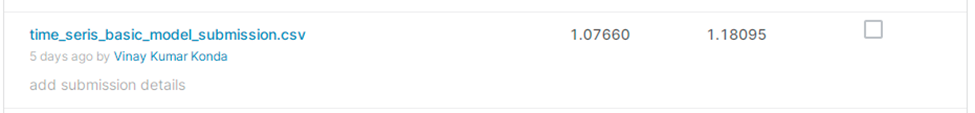

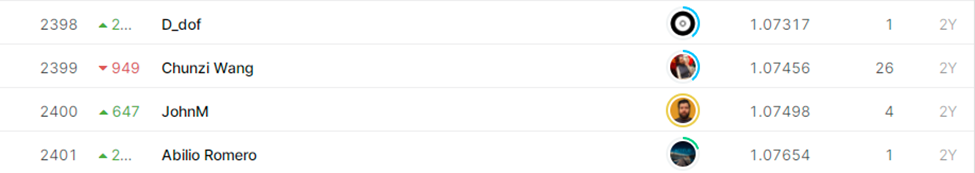

## ML - LGBM Model

In [ ]:
# check lightgbm version
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
from sklearn.metrics import mean_squared_error

### Training

In [ ]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
valid_sets = {f'{store}_valid_fea':pd.DataFrame() for store in store_ids}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}

keys = [k for k in zip(train_sets.keys(),valid_sets.keys(),test_sets.keys())]

results_summay = {'store_id':[], 'model': {}, 'train_rmsse':[], 'valid_rmsse':[], 'train_mse':[], 'valid_mse':[]}

submission_data = {}

for key1, key2, key3 in keys:
  
  store = key1.replace('_train_fea','')
  print('#'*50)
  print('*'*10+' '*3+store+' '*3+'*'*10)
  print('#'*50)
  results_summay['store_id'].append(store)
  
  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  valid_sets[key2] = pd.read_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip')
  test_sets[key3] = pd.read_parquet(drive_path+f'test_sets/{key3}.parquet.gzip')
  print(f'{key1}, {key2} and {key3} :: loading - done')

  # remove '_d' from d column 
  if 'd_' in str(train_sets[key1]['d'][0]):
    train_sets[key1]['d'] = train_sets[key1]['d'].apply(lambda x: int(x.replace('d_','')))
  if 'd_' in str(valid_sets[key2]['d'][0]):
    valid_sets[key2]['d'] = valid_sets[key2]['d'].apply(lambda x: int(x.replace('d_','')))
  if 'd_' in str(test_sets[key3]['d'][0]):
    test_sets[key3]['d'] = test_sets[key3]['d'].apply(lambda x: int(x.replace('d_','')))
  print(f'{key1}, {key2} and {key3} :: pre-process - done')
  print('pre_processing - done')

  x_train, x_valid, y_train, y_valid = train_sets[key1].drop(['id', 'weekday','date','sales'], axis=1), valid_sets[key2].drop(['id', 'weekday','date','sales'], axis=1), train_sets[key1].sales, valid_sets[key2].sales
  x_test = test_sets[key3].drop(['id', 'weekday','date','sales'], axis=1)
  
  print('model training - inprogress...')
  regr = LGBMRegressor(n_estimators=500, objective='regression_l2', metric='rmse')
  regr.fit(x_train, y_train)
  train_sets[key1]['train_pred'] = regr.predict(x_train)
  valid_sets[key2]['valid_pred'] = regr.predict(x_valid)
  test_sets[key3]['test_pred'] = regr.predict(x_test)
  results_summay['model'][store] = regr
  print('model training - done')
  
  train_rmsse = mean_squared_scaled_error(y_train, train_sets[key1]['train_pred'], y_train=y_train, square_root=True)
  valid_rmsse = mean_squared_scaled_error(y_valid, valid_sets[key2]['valid_pred'], y_train=y_train, square_root=True)

  print('Train RMSSE ::', train_rmsse) 
  print('Valid RMSSE ::', valid_rmsse)

  results_summay['train_rmsse'].append(train_rmsse)
  results_summay['valid_rmsse'].append(valid_rmsse)

  train_mse = mean_squared_error(y_train, train_sets[key1]['train_pred'])
  valid_mse = mean_squared_error(y_valid, valid_sets[key2]['valid_pred'])

  print('Train MSE ::', train_mse) 
  print('Valid MSE ::', valid_mse)

  results_summay['train_mse'].append(train_mse)
  results_summay['valid_mse'].append(valid_mse)

  for _id in tqdm(test_sets[key3]['id'].unique()):
    submission_data[_id] = test_sets[key3][test_sets[key3]['id']==_id]['test_pred'].values

  # save files
  train_sets[key1].to_parquet(drive_path+f'train_sets/{key1}.parquet.gzip', compression='gzip')
  valid_sets[key2].to_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip', compression='gzip')
  test_sets[key3].to_parquet(drive_path+f'test_sets/{key3}.parquet.gzip', compression='gzip')
  print(f'{key1}, {key2} and {key3} :: saving - done')

  # delete files
  del train_sets[key1], valid_sets[key2], test_sets[key3]
  print(f'{key1}, {key2} and {key3} :: deletion - done')
  print(' ')
  print(' ')


### Results

In [ ]:
#trained_models = results_summay['model']
pd.to_pickle(trained_models, drive_path+'trained_models_with_500_trees.pkl')
pd.to_pickle(results_summay, drive_path+'results_summary_with_500_trees.pkl')
#results_summay.pop('model')
results = pd.DataFrame(results_summay).sort_values(['train_rmsse', 'valid_rmsse'])
results

### Plot Feature Importance

In [ ]:
models = pd.read_pickle(drive_path+'trained_models_with_500_trees.pkl')
fig, axs = plt.subplots(2,5, figsize=(20,6))
for idx, (store, estimator) in enumerate(models.items()):
    if idx<5:
      lgbm.plot_importance(estimator, ax=axs[0, idx], max_num_features=10, title=store, xlabel='')
    elif idx>=5:
      lgbm.plot_importance(estimator, ax=axs[1, 5-idx], max_num_features=10, title=store, xlabel='')

plt.tight_layout()


### Prepare Submission file for Kaggle

In [ ]:
lgbm_eval_data =  pd.concat([pd.DataFrame({'id':submission_data.keys()}), pd.DataFrame(submission_data.values(), columns=[f'F{i}' for i in range(1,29)])], axis=1)
lgbm_val_data =  pd.concat([pd.DataFrame({'id':[k.replace('evaluation','validation') for k in submission_data.keys()]}), pd.DataFrame(columns=[f'F{i}' for i in range(1,29)])], axis=1)

pd.concat([lgbm_eval_data, lgbm_val_data]).fillna(0.0).to_csv(drive_path+'lgbm_13_jan_2_submission.csv', index=False)

**Observation**

1. Trained the model on each store independently and predictions as well.
2. The training observations were capture in results section.
3. After submiting evaluation test predictions, I got '0.72372' RMSSE under private leaderboard which stands top 12% (670 out of 5558 participants)

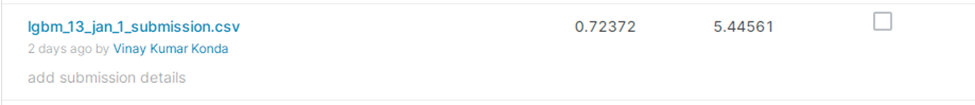

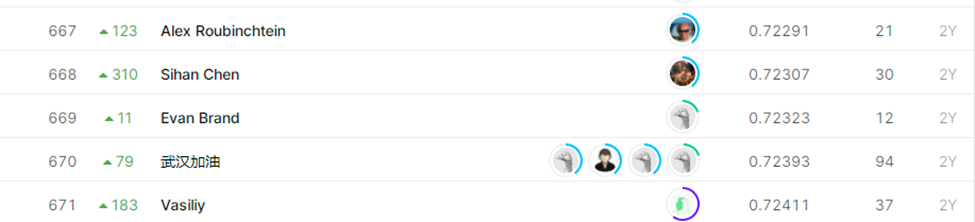


## DL - LSTM - Multioutput

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error


### Utility Methods - Data Prep & Model Creation

In [26]:
def preapre_data_for_training_and_inference(train_fea, valid_fea, test_fea):

  past_28_days = sorted(train_fea.d.unique())[-28:]
  
  X_train, y_train = [], []
  X_valid, y_valid = [], []
  X_test = []
  X_test_ids = []

  train = train_fea[train_fea.d.isin(past_28_days)]
                                              
  for id_ in tqdm(train_fea.id.unique()):
    X_train.append(train[train.id==id_].drop(['id', 'weekday','date','sales', 'train_pred'], axis=1))
    y_train.append(train[train.id==id_].sales)
    X_valid.append(valid_fea[valid_fea.id==id_].drop(['id', 'weekday','date','sales', 'valid_pred'], axis=1))
    y_valid.append(valid_fea[valid_fea.id==id_].sales)
    X_test_ids.append(id_)
    X_test.append(test_fea[test_fea.id==id_].drop(['id', 'weekday','date','sales', 'test_pred'], axis=1))
    
  X_train = np.array(X_train)
  X_valid = np.array(X_valid)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_train=y_train.reshape(y_train.shape[0],y_train.shape[1], 1)
  y_valid = np.array(y_valid)
  y_valid = y_valid.reshape(y_valid.shape[0],y_valid.shape[1], 1)

  print('train ', X_train.shape, y_train.shape)
  print('valid ', X_valid.shape, y_valid.shape)
  print('test ', X_test.shape)

  return X_train, X_valid, y_train, y_valid, X_test, X_test_ids


In [12]:
def create_model(n_input_neurons, optimizer):
  # Configure the neural network model
  model = Sequential()
  n_output_neurons = 28

  model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
  model.add(LSTM(n_input_neurons, return_sequences=False))
  model.add(Dense(n_output_neurons))
  
  # Compile the model
  model.compile(optimizer=optimizer, loss='mse')

  return model


### Training

In [38]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
train_sets = {f'{store}_train_fea':pd.DataFrame() for store in store_ids}
valid_sets = {f'{store}_valid_fea':pd.DataFrame() for store in store_ids}
test_sets = {f'{store}_test_fea':pd.DataFrame() for store in store_ids}


# model hyperparameters
epochs = 10
batch_size = 1
n_input_neurons = 100
lr_rate = 0.001
optimizer = Adam(learning_rate=lr_rate)

numerical_features = ['store_month_min', 'store_month_max', 'store_month_mean', 'store_month_median', 'store_month_std', 'store_wday_min', 'store_wday_max', 'store_wday_mean', 'store_wday_median', 'store_wday_std', 'dept_month_min', 'dept_month_max', 'dept_month_mean', 'dept_month_median', 'dept_month_std', 'dept_wday_min', 'dept_wday_max', 'dept_wday_mean', 'dept_wday_median', 'dept_wday_std', 'item_month_min', 'item_month_max', 'item_month_mean', 'item_month_median', 'item_month_std', 'item_wday_min', 'item_wday_max', 'item_wday_mean', 'item_wday_median', 'item_wday_std', 'sell_price']

keys = [k for k in zip(train_sets.keys(),valid_sets.keys(),test_sets.keys())]

results_summay = {'store_id':[], 'train_rmsse':[], 'valid_rmsse':[], 'train_mse':[], 'valid_mse':[]}

submission_data = {}

for key1, key2, key3 in keys:
  
  store = key1.replace('_train_fea','')
  print('#'*50)
  print('*'*10+' '*3+store+' '*3+'*'*10)
  print('#'*50)
  results_summay['store_id'].append(store)
  
  # load files
  train_sets[key1] = pd.read_parquet(drive_path+f'train_sets/{key1}.parquet.gzip')
  valid_sets[key2] = pd.read_parquet(drive_path+f'valid_sets/{key2}.parquet.gzip')
  test_sets[key3] = pd.read_parquet(drive_path+f'test_sets/{key3}.parquet.gzip')
  print(f'{key1}, {key2} and {key3} :: loading - done')

  # preapre data for training and inference
  X_train, X_valid, y_train, y_valid, X_test, X_test_ids = preapre_data_for_training_and_inference(train_sets[key1], valid_sets[key2], test_sets[key3])
  print(f'{key1}, {key2} and {key3} :: data prepartion - done')

  print('model training - inprogress...')
  model = create_model(n_input_neurons, optimizer)
  
  # Training the model
  history = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs, shuffle=False,
                      validation_data=(X_valid, y_valid)
                    )  
  # saved model
  #model.save(drive_path+f'models/{store}_model')

  # reconstruct the model
  #reconstructed_model = load_model(drive_path+f'models/{store}_model')

  train_pred = model.predict(X_train)
  valid_pred = model.predict(X_valid)
  test_pred = zip(X_test_ids, model.predict(X_test))

  y_train = y_train.reshape(y_train.shape[:2])
  y_valid = y_valid.reshape(y_valid.shape[:2])

  print('model training - done')
  
  train_rmsse = mean_squared_scaled_error(y_train, train_pred, y_train=y_train, square_root=True)
  valid_rmsse = mean_squared_scaled_error(y_valid, valid_pred, y_train=y_train, square_root=True)

  print('Train RMSSE ::', train_rmsse) 
  print('Valid RMSSE ::', valid_rmsse)

  results_summay['train_rmsse'].append(train_rmsse)
  results_summay['valid_rmsse'].append(valid_rmsse)

  train_mse = mean_squared_error(y_train, train_pred)
  valid_mse = mean_squared_error(y_valid, valid_pred)

  print('Train MSE ::', train_mse) 
  print('Valid MSE ::', valid_mse)

  results_summay['train_mse'].append(train_mse)
  results_summay['valid_mse'].append(valid_mse)

  for (_id, pred) in tqdm(test_pred):
    submission_data[_id] = pred
  
  pd.to_pickle(submission_data, drive_path+'submission_data.pkl')

  # delete files
  del train_sets[key1], valid_sets[key2], test_sets[key3]
  print(f'{key1}, {key2} and {key3} :: deletion - done')
  print(' ')
  print(' ')


##################################################
**********   CA_1   **********
##################################################
CA_1_train_fea, CA_1_valid_fea and CA_1_test_fea :: loading - done


100%|██████████| 3049/3049 [01:15<00:00, 40.33it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
CA_1_train_fea, CA_1_valid_fea and CA_1_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 42s 13ms/step - loss: 11.4356 - val_loss: 14.1241
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 11.4625 - val_loss: 14.1530
Epoch 3/10
3049/3049 [==============================] - 40s 13ms/step - loss: 11.4749 - val_loss: 14.1672
Epoch 4/10
3049/3049 [==============================] - 39s 13ms/step - loss: 11.4802 - val_loss: 14.1775
Epoch 5/10
3049/3049 [==============================] - 39s 13ms/step - loss: 11.4870 - val_loss: 14.1644
Epoch 6/10
3049/3049 [==============================] - 39s 13ms/step - loss: 11.4892 - val_loss: 14.1376
Epoch 7/10
3049/3049 [==============================] - 40s 13ms/step - loss: 11.4888 - val_loss: 14.1404
Epoch 8/10
3049/3049 [==============================] - 39s

3049it [00:00, 1108183.09it/s]

CA_1_train_fea, CA_1_valid_fea and CA_1_test_fea :: deletion - done
 
 
##################################################
**********   CA_2   **********
##################################################


CA_2_train_fea, CA_2_valid_fea and CA_2_test_fea :: loading - done


100%|██████████| 3049/3049 [01:12<00:00, 42.11it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
CA_2_train_fea, CA_2_valid_fea and CA_2_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 44s 14ms/step - loss: 9.0066 - val_loss: 10.8162
Epoch 2/10
3049/3049 [==============================] - 41s 13ms/step - loss: 9.0625 - val_loss: 10.8071
Epoch 3/10
3049/3049 [==============================] - 42s 14ms/step - loss: 9.0649 - val_loss: 10.8012
Epoch 4/10
3049/3049 [==============================] - 42s 14ms/step - loss: 9.0662 - val_loss: 10.7983
Epoch 5/10
3049/3049 [==============================] - 42s 14ms/step - loss: 9.0733 - val_loss: 10.7773
Epoch 6/10
3049/3049 [==============================] - 42s 14ms/step - loss: 9.0765 - val_loss: 10.7675
Epoch 7/10
3049/3049 [==============================] - 42s 14ms/step - loss: 9.0798 - val_loss: 10.7610
Epoch 8/10
3049/3049 [==============================] - 43s 14ms/s

3049it [00:00, 1161317.92it/s]

CA_2_train_fea, CA_2_valid_fea and CA_2_test_fea :: deletion - done
 
 
##################################################
**********   CA_3   **********
##################################################


CA_3_train_fea, CA_3_valid_fea and CA_3_test_fea :: loading - done


100%|██████████| 3049/3049 [01:12<00:00, 42.28it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
CA_3_train_fea, CA_3_valid_fea and CA_3_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 13ms/step - loss: 24.1630 - val_loss: 25.5292
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 24.2793 - val_loss: 25.5392
Epoch 3/10
3049/3049 [==============================] - 38s 12ms/step - loss: 24.3373 - val_loss: 25.5058
Epoch 4/10
3049/3049 [==============================] - 38s 12ms/step - loss: 24.3559 - val_loss: 25.4485
Epoch 5/10
3049/3049 [==============================] - 39s 13ms/step - loss: 24.3552 - val_loss: 25.4905
Epoch 6/10
3049/3049 [==============================] - 39s 13ms/step - loss: 24.3462 - val_loss: 25.4834
Epoch 7/10
3049/3049 [==============================] - 38s 13ms/step - loss: 24.2984 - val_loss: 25.5337
Epoch 8/10
3049/3049 [==============================] - 39s

3049it [00:00, 1075833.51it/s]

CA_3_train_fea, CA_3_valid_fea and CA_3_test_fea :: deletion - done
 
 
##################################################
**********   CA_4   **********
##################################################


CA_4_train_fea, CA_4_valid_fea and CA_4_test_fea :: loading - done


100%|██████████| 3049/3049 [01:13<00:00, 41.71it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
CA_4_train_fea, CA_4_valid_fea and CA_4_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 13ms/step - loss: 3.4248 - val_loss: 4.0704
Epoch 2/10
3049/3049 [==============================] - 43s 14ms/step - loss: 3.4247 - val_loss: 4.0870
Epoch 3/10
3049/3049 [==============================] - 38s 13ms/step - loss: 3.4277 - val_loss: 4.0920
Epoch 4/10
3049/3049 [==============================] - 39s 13ms/step - loss: 3.4216 - val_loss: 4.1095
Epoch 5/10
3049/3049 [==============================] - 38s 13ms/step - loss: 3.4233 - val_loss: 4.1191
Epoch 6/10
3049/3049 [==============================] - 38s 12ms/step - loss: 3.4238 - val_loss: 4.1278
Epoch 7/10
3049/3049 [==============================] - 37s 12ms/step - loss: 3.4237 - val_loss: 4.1327
Epoch 8/10
3049/3049 [==============================] - 37s 12ms/step - l

3049it [00:00, 961970.28it/s]

CA_4_train_fea, CA_4_valid_fea and CA_4_test_fea :: deletion - done
 
 
##################################################
**********   TX_1   **********
##################################################


TX_1_train_fea, TX_1_valid_fea and TX_1_test_fea :: loading - done


100%|██████████| 3049/3049 [01:12<00:00, 42.06it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
TX_1_train_fea, TX_1_valid_fea and TX_1_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 12ms/step - loss: 9.1372 - val_loss: 10.3584
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 9.1841 - val_loss: 10.3588
Epoch 3/10
3049/3049 [==============================] - 39s 13ms/step - loss: 9.1989 - val_loss: 10.3589
Epoch 4/10
3049/3049 [==============================] - 39s 13ms/step - loss: 9.2018 - val_loss: 10.3585
Epoch 5/10
3049/3049 [==============================] - 38s 13ms/step - loss: 9.2039 - val_loss: 10.3629
Epoch 6/10
3049/3049 [==============================] - 38s 12ms/step - loss: 9.2066 - val_loss: 10.3594
Epoch 7/10
3049/3049 [==============================] - 38s 13ms/step - loss: 9.2078 - val_loss: 10.3579
Epoch 8/10
3049/3049 [==============================] - 39s 13ms/s

3049it [00:00, 1115237.89it/s]

TX_1_train_fea, TX_1_valid_fea and TX_1_test_fea :: deletion - done
 
 
##################################################
**********   TX_2   **********
##################################################


TX_2_train_fea, TX_2_valid_fea and TX_2_test_fea :: loading - done


100%|██████████| 3049/3049 [01:14<00:00, 40.74it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
TX_2_train_fea, TX_2_valid_fea and TX_2_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 12ms/step - loss: 12.1355 - val_loss: 14.7453
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 12.1919 - val_loss: 14.7808
Epoch 3/10
3049/3049 [==============================] - 38s 13ms/step - loss: 12.1982 - val_loss: 14.7863
Epoch 4/10
3049/3049 [==============================] - 39s 13ms/step - loss: 12.2014 - val_loss: 14.7903
Epoch 5/10
3049/3049 [==============================] - 39s 13ms/step - loss: 12.1968 - val_loss: 14.7990
Epoch 6/10
3049/3049 [==============================] - 38s 13ms/step - loss: 12.1948 - val_loss: 14.8275
Epoch 7/10
3049/3049 [==============================] - 38s 13ms/step - loss: 12.1901 - val_loss: 14.8258
Epoch 8/10
3049/3049 [==============================] - 40s

3049it [00:00, 1196298.68it/s]

TX_2_train_fea, TX_2_valid_fea and TX_2_test_fea :: deletion - done
 
 
##################################################
**********   TX_3   **********
##################################################


TX_3_train_fea, TX_3_valid_fea and TX_3_test_fea :: loading - done


100%|██████████| 3049/3049 [01:14<00:00, 40.84it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
TX_3_train_fea, TX_3_valid_fea and TX_3_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 42s 13ms/step - loss: 10.5809 - val_loss: 13.8031
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 10.6359 - val_loss: 13.7754
Epoch 3/10
3049/3049 [==============================] - 38s 12ms/step - loss: 10.6440 - val_loss: 13.7660
Epoch 4/10
3049/3049 [==============================] - 38s 13ms/step - loss: 10.6458 - val_loss: 13.7377
Epoch 5/10
3049/3049 [==============================] - 38s 13ms/step - loss: 10.6436 - val_loss: 13.7201
Epoch 6/10
3049/3049 [==============================] - 38s 13ms/step - loss: 10.6454 - val_loss: 13.7134
Epoch 7/10
3049/3049 [==============================] - 38s 12ms/step - loss: 10.6474 - val_loss: 13.7005
Epoch 8/10
3049/3049 [==============================] - 39s

3049it [00:00, 960380.96it/s]

TX_3_train_fea, TX_3_valid_fea and TX_3_test_fea :: deletion - done
 
 
##################################################
**********   WI_1   **********
##################################################


WI_1_train_fea, WI_1_valid_fea and WI_1_test_fea :: loading - done


100%|██████████| 3049/3049 [01:13<00:00, 41.73it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
WI_1_train_fea, WI_1_valid_fea and WI_1_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 12ms/step - loss: 5.9664 - val_loss: 7.3303
Epoch 2/10
3049/3049 [==============================] - 38s 12ms/step - loss: 5.9837 - val_loss: 7.3378
Epoch 3/10
3049/3049 [==============================] - 39s 13ms/step - loss: 5.9903 - val_loss: 7.3424
Epoch 4/10
3049/3049 [==============================] - 38s 12ms/step - loss: 5.9847 - val_loss: 7.3371
Epoch 5/10
3049/3049 [==============================] - 38s 12ms/step - loss: 5.9930 - val_loss: 7.3363
Epoch 6/10
3049/3049 [==============================] - 38s 13ms/step - loss: 5.9910 - val_loss: 7.3337
Epoch 7/10
3049/3049 [==============================] - 38s 12ms/step - loss: 5.9957 - val_loss: 7.3265
Epoch 8/10
3049/3049 [==============================] - 39s 13ms/step - l

3049it [00:00, 913459.49it/s]

WI_1_train_fea, WI_1_valid_fea and WI_1_test_fea :: deletion - done
 
 
##################################################
**********   WI_2   **********
##################################################


WI_2_train_fea, WI_2_valid_fea and WI_2_test_fea :: loading - done


100%|██████████| 3049/3049 [01:13<00:00, 41.71it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
WI_2_train_fea, WI_2_valid_fea and WI_2_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 40s 13ms/step - loss: 22.6960 - val_loss: 26.8775
Epoch 2/10
3049/3049 [==============================] - 39s 13ms/step - loss: 22.8927 - val_loss: 26.8593
Epoch 3/10
3049/3049 [==============================] - 40s 13ms/step - loss: 22.9009 - val_loss: 26.8437
Epoch 4/10
3049/3049 [==============================] - 38s 12ms/step - loss: 22.9378 - val_loss: 26.7559
Epoch 5/10
3049/3049 [==============================] - 38s 13ms/step - loss: 22.9153 - val_loss: 26.5893
Epoch 6/10
3049/3049 [==============================] - 39s 13ms/step - loss: 22.9128 - val_loss: 26.6460
Epoch 7/10
3049/3049 [==============================] - 38s 13ms/step - loss: 22.9144 - val_loss: 26.7081
Epoch 8/10
3049/3049 [==============================] - 38s

3049it [00:00, 982214.51it/s]

WI_2_train_fea, WI_2_valid_fea and WI_2_test_fea :: deletion - done
 
 
##################################################
**********   WI_3   **********
##################################################


WI_3_train_fea, WI_3_valid_fea and WI_3_test_fea :: loading - done


100%|██████████| 3049/3049 [01:12<00:00, 42.14it/s]


train  (3049, 28, 61) (3049, 28, 1)
valid  (3049, 28, 61) (3049, 28, 1)
test  (3049, 28, 61)
WI_3_train_fea, WI_3_valid_fea and WI_3_test_fea :: data prepartion - done
model training - inprogress...
Epoch 1/10
3049/3049 [==============================] - 39s 12ms/step - loss: 14.0223 - val_loss: 15.7717
Epoch 2/10
3049/3049 [==============================] - 37s 12ms/step - loss: 14.1273 - val_loss: 15.7817
Epoch 3/10
3049/3049 [==============================] - 38s 12ms/step - loss: 14.1260 - val_loss: 15.7976
Epoch 4/10
3049/3049 [==============================] - 38s 12ms/step - loss: 14.1289 - val_loss: 15.7801
Epoch 5/10
3049/3049 [==============================] - 38s 12ms/step - loss: 14.1246 - val_loss: 15.8087
Epoch 6/10
3049/3049 [==============================] - 38s 12ms/step - loss: 14.1206 - val_loss: 15.8199
Epoch 7/10
3049/3049 [==============================] - 38s 12ms/step - loss: 14.1300 - val_loss: 15.8278
Epoch 8/10
3049/3049 [==============================] - 38s

3049it [00:00, 1096872.19it/s]

WI_3_train_fea, WI_3_valid_fea and WI_3_test_fea :: deletion - done
 
 


### Results

In [39]:
results = pd.DataFrame(results_summay).sort_values(['train_rmsse', 'valid_rmsse'])
results

,store_id,train_rmsse,valid_rmsse,train_mse,valid_mse
8,WI_2,0.760551,0.764686,26.277369,26.563917
6,TX_3,0.760620,0.824332,11.653676,13.687736
4,TX_1,0.765682,0.774637,10.116419,10.354415
9,WI_3,0.767035,0.762711,16.006088,15.826144
3,CA_4,0.767273,0.788644,3.917782,4.139070
2,CA_3,0.772459,0.745441,27.448992,25.562408
0,CA_1,0.774745,0.796357,13.409064,14.167588
5,TX_2,0.778635,0.806622,13.774794,14.782820
7,WI_1,0.936288,0.949338,7.126343,7.326376
1,CA_2,1.031393,1.044552,10.478686,10.747782


### Prepare Submission file for Kaggle

In [40]:
nn_eval_data =  pd.concat([pd.DataFrame({'id':submission_data.keys()}), pd.DataFrame(submission_data.values(), columns=[f'F{i}' for i in range(1,29)])], axis=1)
nn_val_data =  pd.concat([pd.DataFrame({'id':[k.replace('evaluation','validation') for k in submission_data.keys()]}), pd.DataFrame(columns=[f'F{i}' for i in range(1,29)])], axis=1)

pd.concat([nn_eval_data, nn_val_data]).fillna(0.0).to_csv(drive_path+'NN_18_jan_2_submission.csv', index=False)

**Observation**

1. Created multi-output NN trained the model with past 28 days and with 10 epochs on each store independently and predictions as well.
2. The training observations were capture in results section.
3. After submiting evaluation test predictions, I got '4.72230' RMSSE under private leaderboard